【所有性状】
## 将细胞得分的topk细胞作为该性状相关的细胞，计算这些细胞与各个组织中细胞的富集情况
### 可视化 ： 每个性状在各个组织上是否显著 jaccard系数和fishers test
### 可视化 ： 热图展示每个性状显著和不显著的组织 二值化 fishers test p <= 0.005
### 可视化 ： 聚类热图展示每个性状显著和不显著的组织 p连续值 
  

## 49个性状结果分析
### 统计——每个性状显著相关的组织、细胞类型数量分布

## * 49个性状结果

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import os

import matplotlib.pyplot as plt
#战置全局字体大小为12
plt.rcParams['font.size'] = 14

import warnings
# 禁用所有警告
warnings.filterwarnings("ignore")

In [5]:
import os
def makedir(folder_path):
    # 检查文件夹是否已经存在
    if not os.path.exists(folder_path):
        # 文件夹不存在时创建
        os.makedirs(folder_path)
        print(f"文件夹 '{folder_path}' 已创建")
    else:
        print(f"文件夹 '{folder_path}' 已存在，不进行任何处理")

In [6]:
# 遍历文件夹中的指定格式的文件
def openFolderAll(folder_path,desired_extension):
    filelist = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path) and filename.endswith(desired_extension):
            filelist.append(file_path)
    return filelist

In [11]:
core = "core"
# core = "peri"
for trait in range(36,37):
    tissuelist = os.listdir(r"E:\00_CeSOP\results\lcczscore-pip-coreperi-alltraits\%s\%s"%(core,trait))
    results_ct = pd.DataFrame()
    for tissue in tissuelist:
        folder_path = r"E:\00_CeSOP\results\lcczscore-pip-coreperi-alltraits\%s\%s\%s"%(core,trait,tissue)
        # print(folder_path)
        celltypelist = openFolderAll(folder_path,".csv")

        tissue_df = pd.DataFrame()
        for ct in celltypelist:
            celltype = ct.split("\\")[-1].split(".")[0]
            df = pd.read_csv(ct)
            df["celltype"] = celltype
            tissue_df = tissue_df.append(df)
        tissue_df["tissue"] = tissue
        results_ct = results_ct.append(tissue_df)
    results_ct.to_csv(r"E:\00_CeSOP\results\lcczscore-pip-coreperi-alltraits\%s\%s\allcells.csv"%(core,trait))
    print(trait,"finish!")

36 finish!


In [3]:

def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    if union == 0:
        return 0
    else:
        return intersection / union

In [12]:
# 计算超几何分布pvalue
from scipy.stats import hypergeom
# Fisher's 精确检验
import numpy as np
from scipy.stats import fisher_exact

# core = "peri"
core = "core"
index = "lcczscore"
# index = "lcc_expresssum_zscore"
# index = "lcc_expressmean_zscore"
for trait in range(36,37):
    makedir(r"E:\00_CeSOP\results\trait-cells-in-tissues-and-celltypes\tissues\%s"%trait)
    results_ct = pd.read_csv(r"E:\00_CeSOP\results\lcczscore-pip-coreperi-alltraits\%s\%s\allcells.csv"%(core,trait))
    results_ct_sorted = results_ct.sort_values(by=index,ascending=False)
    results_ct_sorted_topk = results_ct_sorted.iloc[:int(len(results_ct_sorted) * (10 / 100))][[index,"tissue","celltype","cell"]]
    
    #  计算超几何分布pvalue
    topkcells = set(list(results_ct_sorted_topk["cell"]))
    tissuelist = os.listdir(r"E:\00_CeSOP\results\asthma\lcczscore-pip-cell-sixpoints")
    result_index = []
    for tissue in tissuelist:
        tissue_cell = results_ct[results_ct['tissue']==tissue]
        tissue_cell_topk = results_ct_sorted_topk[results_ct_sorted_topk['tissue']==tissue]
        tissue_cellnum = len(tissue_cell)
        tissue_cellnum_topk = len(tissue_cell_topk)
    
        # 计算jaccard系数
        jaccard = jaccard_similarity(set(tissue_cell["cell"]),set(tissue_cell_topk["cell"]))
    
        # 计算fisher精确检验pvalue
        b = tissue_cellnum
        a = tissue_cellnum_topk
        observed_table = [[a, b-a], [np.floor(b/10), b - np.floor(b/10)]]  # 2x2 列联表数据
        odds_ratio, p_value = fisher_exact(observed_table, alternative='greater')
    
        # 所有细胞M中与性状相关的细胞有N个，那么某个组织的n个细胞中有k个性状相关细胞是否显著高
        M = len(results_ct_sorted)
        N = len(results_ct_sorted_topk)
        n = tissue_cellnum
        k = tissue_cellnum_topk
        Hpvalue = hypergeom.sf(k-1,M,N,n)
    
        result_index.append([tissue,tissue_cellnum,tissue_cellnum_topk,
                       jaccard,p_value,Hpvalue])
    
    result_index_df = pd.DataFrame(result_index)
    result_index_df.columns = ["tissue","cellnum","relatedCellnum","jaccard","fisher's pvalue","hypergeom pvalue"]
    result_index_df.to_csv(r"E:\00_CeSOP\results\trait-cells-in-tissues-and-celltypes\tissues\%s\top10_%s_lcczscore.csv"%(trait,core))


文件夹 'E:\00_CeSOP\results\trait-cells-in-tissues-and-celltypes\tissues\36' 已存在，不进行任何处理


In [13]:
## 细胞类型
# core = "peri"
core = "core"
index = "lcczscore"
# index = "lcc_expresssum_zscore"
# index = "lcc_expressmean_zscore"
for trait in range(36,37):
    makedir(r"E:\00_CeSOP\results\trait-cells-in-tissues-and-celltypes\celltypes\%s"%trait)
    results_ct = pd.read_csv(r"E:\00_CeSOP\results\lcczscore-pip-coreperi-alltraits\%s\%s\allcells.csv"%(core,trait))
    
    results_ct_sorted = results_ct.sort_values(by=index,ascending=False)
    results_ct_sorted_topk = results_ct_sorted.iloc[:int(len(results_ct_sorted) * (10 / 100))][[index,"tissue","celltype","cell"]]
    
    #  计算超几何分布pvalue
    topkcells = set(list(results_ct_sorted_topk["cell"]))
    results_ct_group = results_ct.groupby(["tissue","celltype"])
    # tissuelist = os.listdir(r"E:\00_CeSOP\results\asthma\lcczscore-pip-cell-sixpoints")
    result_index = []
    # for tissue in tissuelist:
    
    for index0, group in results_ct_group:
        tissue_cell = results_ct[(results_ct['tissue']==index0[0]) & (results_ct['celltype']==index0[1])]
        tissue_cell_topk = results_ct_sorted_topk[(results_ct_sorted_topk['tissue']==index0[0])  & (results_ct_sorted_topk['celltype']==index0[1])]
        tissue_cellnum = len(tissue_cell)
        tissue_cellnum_topk = len(tissue_cell_topk)
        
        # 计算jaccard系数
        jaccard = jaccard_similarity(set(tissue_cell["cell"]),set(tissue_cell_topk["cell"]))
    
        # 计算fisher精确检验pvalue
        b = tissue_cellnum
        a = tissue_cellnum_topk
        observed_table = [[a, b-a], [np.floor(b/10), b - np.floor(b/10)]]  # 2x2 列联表数据
        odds_ratio, p_value = fisher_exact(observed_table, alternative='greater')
    
        # 所有细胞M中与性状相关的细胞有N个，那么某个组织的n个细胞中有k个性状相关细胞是否显著高
        M = len(results_ct_sorted)
        N = len(results_ct_sorted_topk)
        n = tissue_cellnum
        k = tissue_cellnum_topk
        Hpvalue = hypergeom.sf(k-1,M,N,n)
    
        result_index.append([index0[0],index0[1],tissue_cellnum,tissue_cellnum_topk,
                       jaccard,p_value,Hpvalue])
    
    result_index_df = pd.DataFrame(result_index)
    result_index_df.columns = ["tissue","celltype","cellnum","relatedCellnum","jaccard","fisher's pvalue","hypergeom pvalue"]
    result_index_df.to_csv(r"E:\00_CeSOP\results\trait-cells-in-tissues-and-celltypes\celltypes\%s\top10_%s_lcczscore.csv"%(trait,core))

文件夹 'E:\00_CeSOP\results\trait-cells-in-tissues-and-celltypes\celltypes\36' 已存在，不进行任何处理


## 可视化
### 1. 

### 3. 热图展示每个性状显著和不显著的组织 fisher test pvalue连续

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np
import scanpy as sc

plt.rcParams['font.family'] = ' Times New Roman, SimSun'  # 设置字体族，中文为SimSun，英文为Times New Roman
plt.rcParams['mathtext.fontset'] = 'stix'  # 设置数学公式字体为stix
# 设置全局字体大小
plt.rcParams['font.size'] = 12  # 设置全局字体大小

import warnings

# 禁用所有警告
warnings.filterwarnings("ignore")

epsilon = 1e-10
core = "core"
traits_name = pd.read_excel(r"E:\00_CeSOP\results\49_traits.xlsx")
alltraits_significant = pd.DataFrame()
for trait in range(1, 50):
    trait_name = traits_name[traits_name["Number"] == trait]["Trait name"].values[0]
    # trait_name = traits_name[traits_name["Number"] == trait]["Trait 名字"].values[0]
    df = pd.read_csv(
        r"E:\00_CeSOP\results\trait-cells-in-tissues-and-celltypes\tissues\%s\top10_%s_lcczscore.csv" % (trait, core))
    df = df.sort_values("tissue")
    df["log fisher's pvalue"] = -np.log10(df["fisher's pvalue"] + + epsilon)
    alltraits_significant[trait_name] = df["log fisher's pvalue"]

    # df["log hypergeom pvalue"] = -np.log10(df["hypergeom pvalue"] + + epsilon)
    # alltraits_significant[trait_name] = df["log hypergeom pvalue"]
#     

## 使用组织的中文名称
names = pd.read_excel(r"E:\00_CeSOP\results\tissues-names.xlsx")
# 将列 'a' 转换为分类类型，并按照列表 l 的顺序排序
names['tissue'] = pd.Categorical(names['tissue'], categories=df["tissue"], ordered=True)
# 按照列 'a' 进行排序
names = names.sort_values('tissue')
# 重置索引（可选）
names = names.reset_index(drop=True)
alltraits_significant.index = names['name']
# alltraits_significant.index = df["tissue"]

In [4]:
alltraits_significant.index = df["tissue"]
alltraits_significant

Cholesterol       Glucose         HbA1c  HDL Cholesterol  \
tissue                                                                       
Bladder          2.660583e-01 -4.342849e-11  1.000000e+01     1.000000e+01   
Blood           -4.342945e-11  1.189675e-01  1.000000e+01    -4.342945e-11   
Bone_Marrow     -4.342945e-11  9.999990e+00  1.768503e-04    -4.342945e-11   
Eye              1.000000e+01  9.999962e+00  1.279867e-09     5.607920e-07   
Fat              1.000000e+01 -4.342945e-11  9.999989e+00     1.000000e+01   
Heart            1.000000e+01  9.049539e-01 -4.342945e-11    -4.342945e-11   
Kidney          -4.342945e-11  9.999964e+00 -3.677791e-11     1.000000e+01   
Large_Intestine -4.342945e-11  9.949719e+00  3.835549e+00     6.395463e-01   
Liver            1.000000e+01  6.880257e+00  1.917400e-08     1.000000e+01   
Lung             1.000000e+01 -4.342945e-11 -4.342945e-11     1.000000e+01   
Lymph_Node      -4.342945e-11  1.000000e+01  2.703273e-01    -4.342945e-11   
Mammary          8.711948e-08  1.923053e-04  9.873982e-07    -4.342926e-11   
Muscle           3.745167e-03 -4.342945e-11 -4.342945e-11    -4.342945e-11   
Pancreas         1.144898e+00  1.298365e+00 -4.342945e-11     2.563187e+00   
Prostate        -4.342945e-11  7.465357e-06 -4.342945e-11     1.102624e-03   
Salivary_Gland   8.527672e+00  2.751839e-03 -4.342945e-11    -4.342945e-11   
Skin            -4.342945e-11 -4.342945e-11  3.462343e-03    -4.342945e-11   
Small_Intestine -4.342945e-11  1.645421e-06  1.072514e-03    -4.342945e-11   
Spleen          -4.342945e-11  1.000000e+01  1.312152e-02    -4.342945e-11   
Thymus          -3.910888e-11  2.354437e-01  3.675218e-02    -4.342232e-11   
Tongue           7.980089e+00  3.636467e+00 -4.342945e-11    -4.264073e-11   
Trachea          9.686240e+00  5.825139e-02  4.540744e-05     2.582474e-04   
Uterus           1.000000e+01  5.997256e-02  9.330151e-04     6.479799e-03   
Vasculature      1.000000e+01 -4.342945e-11  2.486017e-06     1.000000e+01   

                 LDL Cholesterol  Triglycerides     Vitamin D  \
tissue                                                          
Bladder            -4.342945e-11   9.999784e+00  1.066444e-09   
Blood              -4.342251e-11  -4.342945e-11  1.000000e+01   
Bone_Marrow         3.297473e+00   9.234015e-01  1.000000e+01   
Eye                 9.991600e+00   3.254176e+00 -4.342945e-11   
Fat                 1.051328e-03   9.999950e+00  2.626726e-01   
Heart               1.000000e+01   1.000000e+01 -4.342945e-11   
Kidney             -4.342945e-11   2.465589e-01 -4.342945e-11   
Large_Intestine     2.721593e+00   8.927311e-08  3.071464e-02   
Liver               1.000000e+01   1.000000e+01  8.943328e+00   
Lung                1.000000e+01   1.000000e+01  8.032697e-01   
Lymph_Node         -4.342945e-11  -4.342945e-11  9.999999e+00   
Mammary             1.557638e-06   3.490622e+00 -4.342945e-11   
Muscle             -4.342945e-11   1.272284e+00 -4.342945e-11   
Pancreas            9.979784e-03   1.000000e+01  1.700896e+00   
Prostate           -4.342945e-11   6.335560e+00 -4.239010e-11   
Salivary_Gland      2.920383e-02   5.424268e-10  1.519939e-02   
Skin               -4.342945e-11   1.061594e-01 -4.342945e-11   
Small_Intestine     1.834635e-03   2.086730e+00  5.827137e+00   
Spleen              4.489131e-01  -4.342945e-11  1.000000e+01   
Thymus             -4.334623e-11  -4.342945e-11  2.574247e+00   
Tongue              1.000000e+01  -4.342945e-11 -4.342945e-11   
Trachea             9.992298e+00   2.206713e+00 -3.763105e-11   
Uterus              1.000000e+01   3.335339e+00  4.003750e-06   
Vasculature         9.388970e-02   1.000000e+01  1.309982e+00   

                 Eosinophil Count  High Light Scatter Retic. Count  \
tissue                                                               
Bladder              8.317624e+00                     3.085341e-02   
Blood                9.999990e+00                     2.258587e+00   
Bone_Marrow       

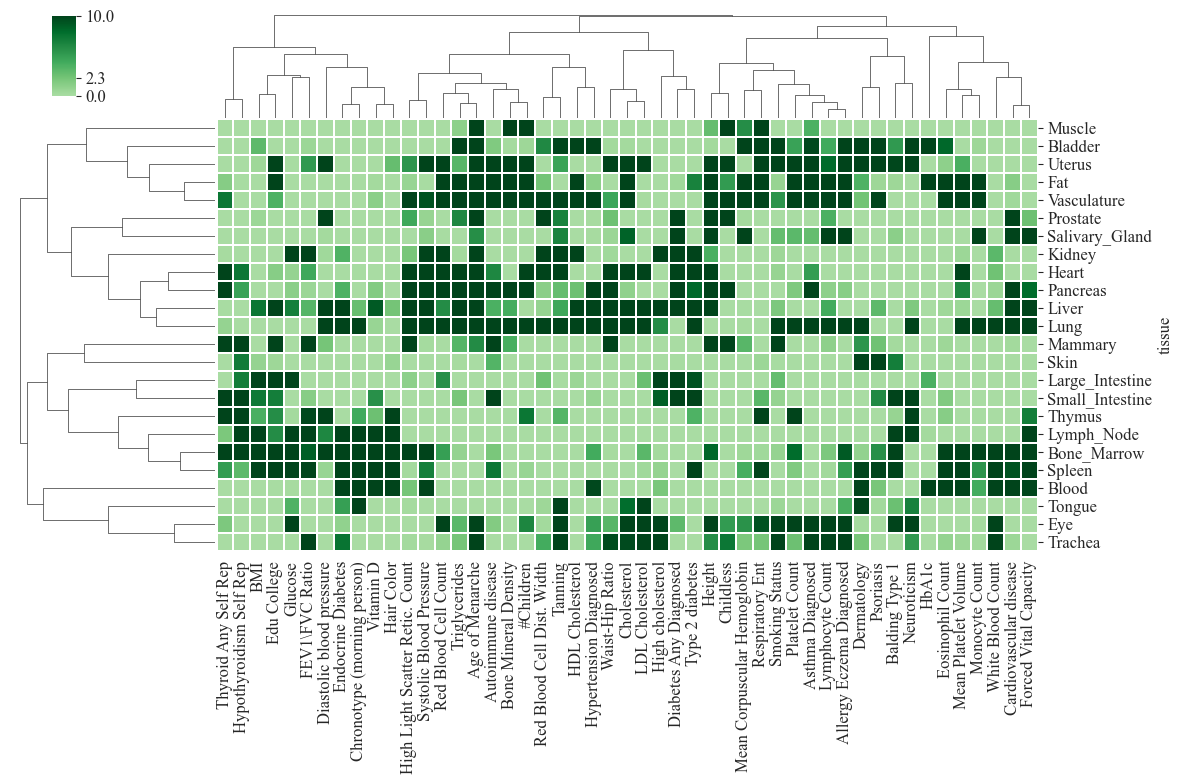

In [5]:
import seaborn as sns
# 创建热图
x = -np.log10(0.005 + epsilon)

g = sns.clustermap(alltraits_significant, cmap='Greens', figsize=(12, 8),  
               yticklabels=True ,  xticklabels=True,linewidths = 0.05, 
                   method='complete', metric='cosine',
                   cbar_pos=(0.05, 0.87, 0.02, 0.1),
                   cbar_kws={'ticks':[0,x,10]},
                   center=x)

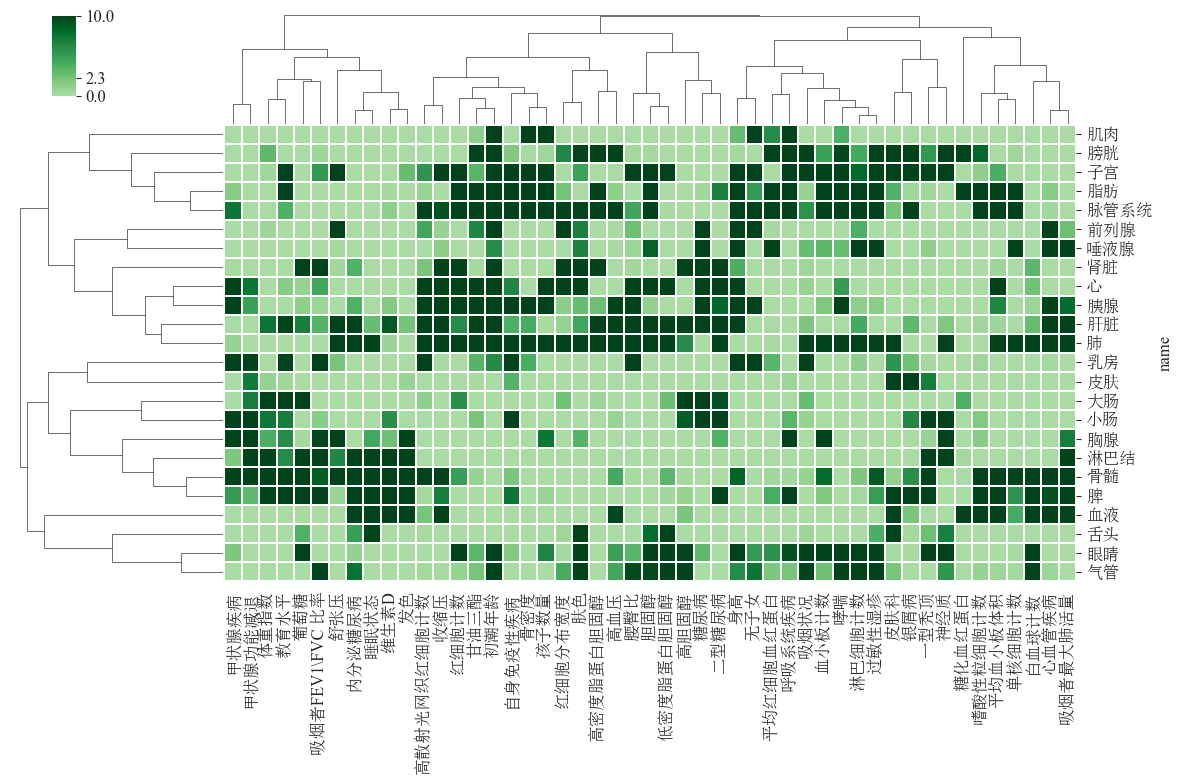

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np
import scanpy as sc


plt.rcParams['font.family']=' Times New Roman, SimSun'# 设置字体族，中文为SimSun，英文为Times New Roman
plt.rcParams['mathtext.fontset'] = 'stix' # 设置数学公式字体为stix
# 设置全局字体大小
plt.rcParams['font.size'] = 12  # 设置全局字体大小

import warnings
# 禁用所有警告
warnings.filterwarnings("ignore")

epsilon = 1e-10
core = "core"
traits_name = pd.read_excel(r"E:\00_CeSOP\results\49_traits.xlsx")
alltraits_significant = pd.DataFrame()
for trait in range(1,50):
    trait_name = traits_name[traits_name["Number"] == trait]["Trait name"].values[0]
    # trait_name = traits_name[traits_name["Number"] == trait]["Trait 名字"].values[0]
    df = pd.read_csv(r"E:\00_CeSOP\results\trait-cells-in-tissues-and-celltypes\tissues\%s\top10_%s_lcczscore.csv"%(trait,core))
    df = df.sort_values("tissue")  
    df["log fisher's pvalue"] = -np.log10(df["fisher's pvalue"] + + epsilon)
    alltraits_significant[trait_name] = df["log fisher's pvalue"]
    
    # df["log hypergeom pvalue"] = -np.log10(df["hypergeom pvalue"] + + epsilon)
    # alltraits_significant[trait_name] = df["log hypergeom pvalue"]
#     

## 使用组织的中文名称
names = pd.read_excel(r"E:\00_CeSOP\results\tissues-names.xlsx")
# 将列 'a' 转换为分类类型，并按照列表 l 的顺序排序
names['tissue'] = pd.Categorical(names['tissue'], categories=df["tissue"], ordered=True)
# 按照列 'a' 进行排序
names = names.sort_values('tissue')
# 重置索引（可选）
names = names.reset_index(drop=True)
alltraits_significant.index = names['name']
# alltraits_significant.index = df["tissue"]


import seaborn as sns
# 创建热图
x = -np.log10(0.005 + epsilon)

g = sns.clustermap(alltraits_significant, cmap='Greens', figsize=(12, 8),  
               yticklabels=True ,  xticklabels=True,linewidths = 0.05, 
                   method='complete', metric='cosine',
                   cbar_pos=(0.05, 0.87, 0.02, 0.1),
                   cbar_kws={'ticks':[0,x,10]},
                   center=x)

# 隐藏轴标签
# g.ax_heatmap.set_xticklabels([])  # 隐藏 X 轴标签
# 保存图片到文件
g.savefig(r"E:\00_CeSOP\results\figures\clustermap_core_49traits_fisherpvalue.png", dpi=300) 
# 调整透明度
# g.ax_heatmap.collections[0].set_alpha(0.6)  # 设置透明度为 0.5
# g.ax_heatmap.collections[0].set_alpha(1)  # 设置透明度为 0.5
# g.cax.set_visible(False)

No NaN or inf values in the data.


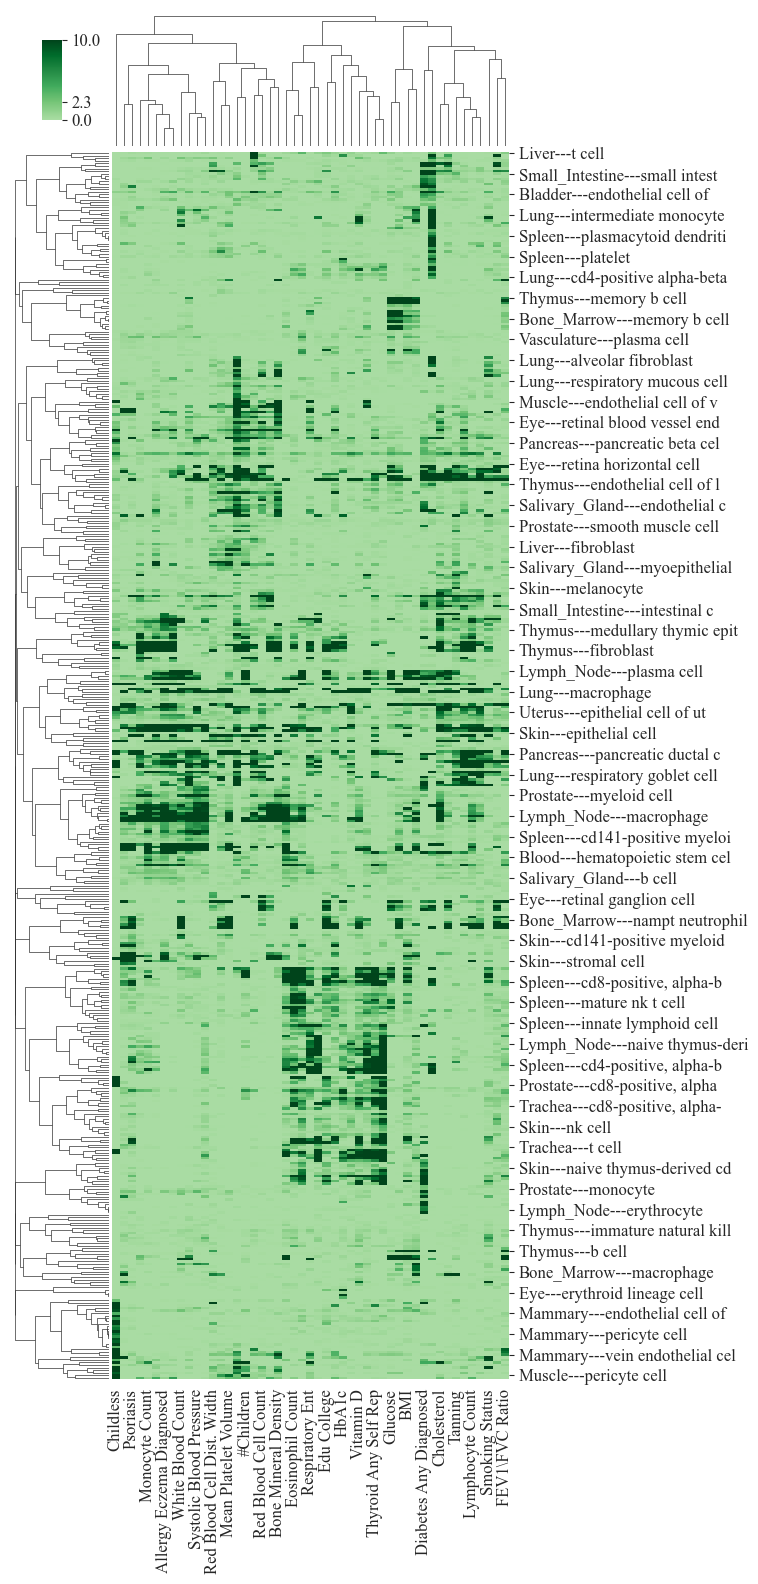

In [70]:
## 细胞类型
import matplotlib as mpl
# 设置中文字体
# mpl.rcParams['font.sans-serif'] = ['SimHei']
# # 设置英文字体为 Times New Roman
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman']
epsilon = 1e-10
core = "core"
# core = "peri"
traits_name = pd.read_excel(r"E:\00_CeSOP\data\49_traits.xlsx")
alltraits_significant = pd.DataFrame()
for trait in range(1,50):
    trait_name = traits_name[traits_name["Number"] == trait]["Trait name"].values[0]
    # trait_name = traits_name[traits_name["Number"] == trait]["Trait 名字"].values[0]
    df = pd.read_csv(r"E:\00_CeSOP\results\trait-cells-in-tissues-and-celltypes\celltypes\%s\top10_%s_lcczscore.csv"%(trait,core))
    df = df.sort_values(["tissue","celltype"])  
    df["log fisher's pvalue"] = -np.log10(df["fisher's pvalue"] + + epsilon)
    alltraits_significant[trait_name] = df["log fisher's pvalue"]
alltraits_significant.index = df["tissue"] + "---" + df["celltype"]
# 处理NaN和inf值
alltraits_significant = alltraits_significant.replace([np.inf, -np.inf], np.nan).dropna()
# 检查是否有NaN或inf值
if alltraits_significant.isnull().values.any():
    print("Data contains NaN or inf values.")
else:
    print("No NaN or inf values in the data.")
    
import seaborn as sns
# 创建热图
x = -np.log10(0.005 + epsilon)
g = sns.clustermap(alltraits_significant, cmap='Greens', figsize=(10, 16),  linewidths = 0.002,
                    # xticklabels=True ,  
                   method='complete', metric='cosine',
                   cbar_pos=(0.05, 0.92, 0.02, 0.05),
                   cbar_kws={'ticks':[0,x,10]},
                   dendrogram_ratio=(0.2, 0.1),
                   center=x)
# 获取横轴和纵轴的标签
xticklabels = g.ax_heatmap.get_xticklabels()
yticklabels = g.ax_heatmap.get_yticklabels()

# 截断横轴标签（最多30个字符）
g.ax_heatmap.set_xticklabels([label.get_text()[:30] for label in xticklabels])

# 截断纵轴标签（最多30个字符）
g.ax_heatmap.set_yticklabels([label.get_text()[:30] for label in yticklabels])
g.savefig(r"E:\00_CeSOP\results\figures\clustermap_core_49traits_fisherpvalue_celltypes.png", dpi=300) 
# 显示图像
plt.show()
# 调整透明度
g.ax_heatmap.collections[0].set_alpha(0.6)  # 设置透明度为 0.5
g.ax_heatmap.collections[0].set_alpha(1)  # 设置透明度为 0.5
# g.cax.set_visible(False)

### 计算性状相似性 （根据性状在每个组织上的pvalue，计算两两性状之间的cosine）

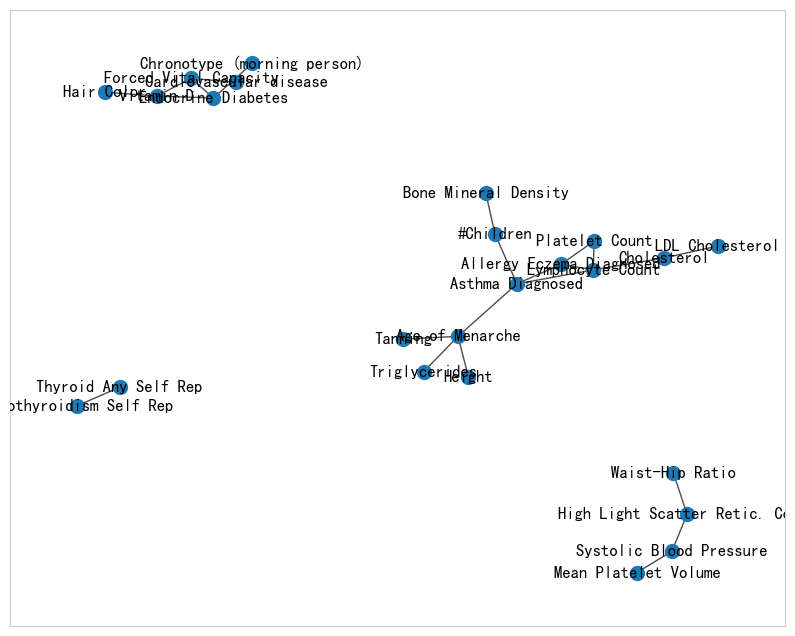

In [271]:
from scipy.spatial.distance import cosine
epsilon = 1e-10
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
core = "core"
# core = "peri"
traits_name = pd.read_excel(r"E:\00_CeSOP\data\49_traits.xlsx")
alltraits_significant = pd.DataFrame()
for trait in range(1,50):
    trait_name = traits_name[traits_name["Number"] == trait]["Trait name"].values[0]
    # trait_name = traits_name[traits_name["Number"] == trait]["Trait 名字"].values[0]
    df = pd.read_csv(r"E:\00_CeSOP\results\trait-cells-in-tissues-and-celltypes\tissues\%s\top10_%s_lcczscore.csv"%(trait,core))
    df = df.sort_values("tissue")  
    df["log fisher's pvalue"] = -np.log10(df["fisher's pvalue"] + + epsilon)
    alltraits_significant[trait_name] = df["log fisher's pvalue"]
alltraits_significant.index = df["tissue"]
# 计算每两列之间的余弦相似度
# 初始化一个空的 DataFrame 用于存储余弦相似度
cosine_similarities = pd.DataFrame(index=alltraits_significant.columns, columns=alltraits_significant.columns)
for col1 in alltraits_significant.columns:
    for col2 in alltraits_significant.columns:
        if col1 != col2:
            cosine_similarities.loc[col1, col2] = 1 - cosine(alltraits_significant[col1], alltraits_significant[col2])
        else:
            cosine_similarities.loc[col1, col2] = 1  # 自身与自身的相似度为1

# 转换为数值类型
cosine_similarities = cosine_similarities.astype(float)
cosine_similarities.to_csv(r"E:\00_CeSOP\results\traits_cosine_similarity_for_tissues.csv")

'''可视化'''
# 创建一个空的NetworkX图
G = nx.Graph()
# 添加节点和边，设置阈值为0.3
threshold = 0.8
for i in cosine_similarities.columns:
    for j in cosine_similarities.columns:
        if i != j and abs(cosine_similarities.loc[i, j]) > threshold:  # 取绝对值并设置阈值
            G.add_edge(i, j, weight=cosine_similarities.loc[i, j])

# 检查图中是否有边
if len(G.edges) == 0:
    print("No edges in the graph. Try lowering the threshold.")
else:
    # 设置节点位置
    pos = nx.spring_layout(G)  # 其他布局方式包括: circular_layout, random_layout, etc.

    # 画图
    plt.figure(figsize=(10, 8))
    nx.draw_networkx_nodes(G, pos, node_size=100)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.7)
    nx.draw_networkx_labels(G, pos, font_size=12)

    # 添加边权重标签
    edge_labels = nx.get_edge_attributes(G, 'weight')
    # nx.draw_networkx_edge_labels(G, pos, edge_labels={(i, j): f'{w:.2f}' for (i, j, w) in G.edges(data='weight')})
    plt.grid(False)
    # plt.title('Network Graph from Correlation Matrix')
    plt.show()

### 输出clustermap聚类的结果

In [158]:
## 根据最大轮廓系数选择聚类簇
def bestNclusters(linkage_matrix,array):
    ''' 
    :param linkage_matrix: 层次聚类矩阵
    :param array:  数据矩阵
    :return: 最优（最大轮廓系数）簇数
    '''
    # 计算不同簇数的轮廓系数
    silhouette_scores = {}
    for n_clusters in range(2, 10):  # 假设我们尝试从2到10个簇
        cluster_assignments = sch.fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')
        score = silhouette_score(array, cluster_assignments,metric="cosine")
        silhouette_scores[n_clusters] = score
        print(f'Number of clusters: {n_clusters}, Silhouette Score: {score}')
    # 选择轮廓系数最高的簇数
    best_n_clusters = max(silhouette_scores, key=silhouette_scores.get)
    return best_n_clusters

Silhouette Score: 0.20657245232944585
Calinski-Harabasz Score: 6.620166650714335


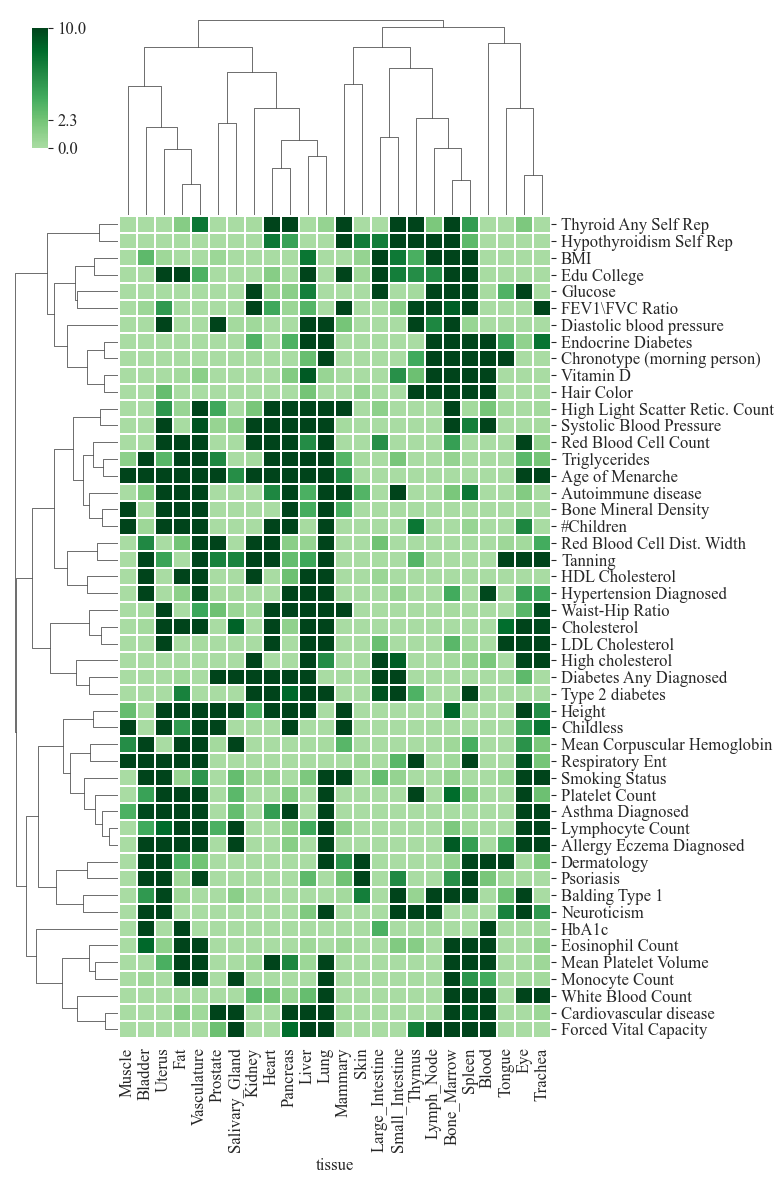

In [50]:
'''根据组织特异性对性状进行聚类，并输出聚类结果'''
import seaborn as sns
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

epsilon = 1e-10
core = "core"
traits_name = pd.read_excel(r"E:\00_CeSOP\data\49_traits.xlsx")
alltraits_significant = pd.DataFrame()
for trait in range(1, 50):
    trait_name = traits_name[traits_name["Number"] == trait]["Trait name"].values[0]
    # trait_name = traits_name[traits_name["Number"] == trait]["Trait 名字"].values[0]
    df = pd.read_csv(
        r"E:\00_CeSOP\results\trait-cells-in-tissues-and-celltypes\tissues\%s\top10_%s_lcczscore.csv" % (trait, core))
    df = df.sort_values("tissue")
    df["log fisher's pvalue"] = -np.log10(df["fisher's pvalue"] + + epsilon)
    alltraits_significant[trait_name] = df["log fisher's pvalue"]
alltraits_significant.index = df["tissue"]

'''层次聚类'''
alltraits_significant_T = alltraits_significant.T
x = -np.log10(0.005 + epsilon)
cg = sns.clustermap(alltraits_significant_T, cmap='Greens', figsize=(8, 12), linewidths=0.01,
                    xticklabels=True, yticklabels=True,
                    method='complete', metric='cosine',
                    cbar_pos=(0.05, 0.87, 0.02, 0.1),
                    cbar_kws={'ticks': [0, x, 10]},
                    center=x)  #行是组织，列是性状

# plt.show()

'''计算每两列(性状）之间的余弦相似度'''
cosine_similarities = pd.DataFrame(index=alltraits_significant.columns, columns=alltraits_significant.columns)
for col1 in alltraits_significant.columns:
    for col2 in alltraits_significant.columns:
        if col1 != col2:
            cosine_similarities.loc[col1, col2] = 1 - cosine(alltraits_significant[col1], alltraits_significant[col2])
        else:
            cosine_similarities.loc[col1, col2] = 1  # 自身与自身的相似度为1
# 转换为数值类型
cosine_similarities = cosine_similarities.astype(float)
# 转换为一维数组，提取两两之间的相关系数
correlation_list = []
rows, cols = cosine_similarities.shape
for i in range(rows):
    for j in range(i + 1, cols):
        correlation_list.append(
            (cosine_similarities.index[i], cosine_similarities.columns[j], cosine_similarities.iat[i, j]))
# 转换为DataFrame并显示
correlation_df = pd.DataFrame(correlation_list, columns=['Node1', 'Node2', 'value'])
# correlation_df.to_csv(r"E:\00_CeSOP\results\temp\cytoscape\traits_cosine_similarity_for_tissues\edges.csv", index=None)

'''提取聚类结果'''
# 计算余弦距离矩阵
cosine_distance = pdist(alltraits_significant_T, metric='cosine')  # Transpose to calculate column distances
# 生成层次聚类
linkage_matrix = sch.linkage(cosine_distance, method='complete')
# 划分簇，设置簇数为3
array = alltraits_significant_T.iloc[:, 0:-1].to_numpy()
# best_n_cluster = bestNclusters(linkage_matrix,array)
# print(best_n_cluster)
cluster_assignments = sch.fcluster(linkage_matrix, t=2, criterion='maxclust')
# 添加簇分配结果到 DataFrame
alltraits_significant_T['Cluster'] = cluster_assignments
# alltraits_significant_T['Cluster'].to_csv(r"E:\00_CeSOP\results\temp\cytoscape\traits_cosine_similarity_for_tissues\nodes.csv")

'''计算轮廓系数'''
from sklearn.metrics import silhouette_score
sil_score = silhouette_score(array, cluster_assignments,metric="cosine")
print(f'Silhouette Score: {sil_score}')

'''计算 CH 指数'''
from sklearn.metrics import calinski_harabasz_score
ch_score = calinski_harabasz_score(array, cluster_assignments)
print(f'Calinski-Harabasz Score: {ch_score}')

([<matplotlib.axis.XTick at 0x256de9d73d0>,
 [Text(1, 0, 'Intra'), Text(2, 0, 'Inter')])

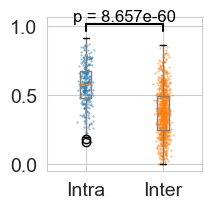

In [164]:
'''根据聚类结果计算簇内相似性与簇外相似性，做显著性检验'''
intra_corr = []
inter_corr = []
for i in range(1, 5):
    group1 = list(alltraits_significant_T[alltraits_significant_T["Cluster"]==i].index)
    filtered_df = correlation_df[correlation_df['Node1'].isin(group1) & correlation_df['Node2'].isin(group1)]
    intra_corr.extend(list(filtered_df['value']))  #簇内

    filtered_df1 = correlation_df[correlation_df['Node1'].isin(group1) & ~correlation_df['Node2'].isin(group1)]
    inter_corr.extend(list(filtered_df1['value']))     # 簇间

corr_list =  [intra_corr,inter_corr]
# 散点箱线图
# 设置图形大小
plt.figure(figsize=(2, 2))
# 创建箱线图
box = plt.boxplot(corr_list,boxprops=dict(color='grey'), whiskerprops=dict(color='grey'))
# 绘制散点图
for i, d in enumerate(corr_list, 1):
    y = d
    x = np.random.normal(i, 0.04, size=len(y))  # 在x轴位置上添加一些随机抖动
    plt.scatter(x, y, alpha=0.6,s = 0.2)

from scipy.stats import ttest_ind
# 计算 p 值
t_stat, p_value = ttest_ind(intra_corr, inter_corr)

# 在箱体之间添加标示线和 p 值
x1, x2 = 1, 2
y, h, col = max(max(intra_corr),max(inter_corr)) + 0.05, 0.05, 'k'
plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
plt.text((x1 + x2) * .5, y + h, f"p = {p_value:.3e}", ha='center', va='bottom', color=col, fontsize=12)

# 设置自定义横轴坐标值和标签
custom_ticks = [1, 2]  # 自定义的横轴坐标值
custom_labels = ["Intra","Inter"]  # 对应的标签
plt.xticks(custom_ticks, custom_labels)

Silhouette Score: 0.47048794715633024
Calinski-Harabasz Score: 24.67162213801395


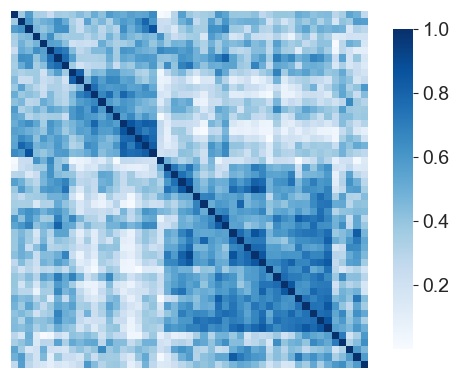

In [3]:
'''根据性状之间的相似性对性状进行重新聚类，性状之间的相似性是对组织特异性向量计算cosine相似性得到的'''
import seaborn as sns
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

epsilon = 1e-10
core = "core"
traits_name = pd.read_excel(r"E:\00_CeSOP\data\49_traits.xlsx")
alltraits_significant = pd.DataFrame()
for trait in range(1, 50):
    trait_name = traits_name[traits_name["Number"] == trait]["Trait name"].values[0]
    # trait_name = traits_name[traits_name["Number"] == trait]["Trait 名字"].values[0]
    df = pd.read_csv(
        r"E:\00_CeSOP\results\trait-cells-in-tissues-and-celltypes\tissues\%s\top10_%s_lcczscore.csv" % (trait, core))
    df = df.sort_values("tissue")
    df["log fisher's pvalue"] = -np.log10(df["fisher's pvalue"] + + epsilon)
    alltraits_significant[trait_name] = df["log fisher's pvalue"]
alltraits_significant.index = df["tissue"]
alltraits_significant_T = alltraits_significant.T

'''计算每两列(性状）之间的余弦相似度'''
cosine_similarities = pd.DataFrame(index=alltraits_significant.columns, columns=alltraits_significant.columns)
for col1 in alltraits_significant.columns:
    for col2 in alltraits_significant.columns:
        if col1 != col2:
            cosine_similarities.loc[col1, col2] = 1 - cosine(alltraits_significant[col1], alltraits_significant[col2])
        else:
            cosine_similarities.loc[col1, col2] = 1  # 自身与自身的相似度为1
# 转换为数值类型
cosine_similarities = cosine_similarities.astype(float)

g = sns.clustermap(cosine_similarities, cmap='Blues', 
                   figsize=(4, 4), linewidths=0,
                   xticklabels=False, yticklabels=False,
                   dendrogram_ratio=(0.001, 0.001),
                   # method='average', metric='euclidean',
                   # method='complete', metric='euclidean',
                   method='complete', metric='cosine',
                   cbar_pos=(1.01, 0.1, 0.05, 0.8),
                   center=0.5)
# g = sns.clustermap(cosine_similarities, cmap='Blues', figsize=(10, 12), linewidths=0,
#                    xticklabels=False, yticklabels=True,
#                    # method='average', metric='euclidean',
#                    method='complete', metric='cosine',
#                    center=0.45)

cosine_similarities_T = cosine_similarities.T

'''提取聚类结果'''
# 计算余弦距离矩阵
cosine_distance = pdist(cosine_similarities_T, metric='cosine')  # Transpose to calculate column distances
# 生成层次聚类
linkage_matrix = sch.linkage(cosine_distance, method='complete')
# 划分簇，设置簇数为3
array = cosine_similarities_T.iloc[:, 0:-1].to_numpy()
cluster_assignments = sch.fcluster(linkage_matrix, t=2, criterion='maxclust')
# 添加簇分配结果到 DataFrame
cosine_similarities_T['Cluster'] = cluster_assignments
cosine_similarities_T['Cluster'].to_csv(
    r"E:\00_CeSOP\results\temp\cytoscape\traits_cosine_similarity_for_tissues\nodes11.csv")

'''计算轮廓系数'''
from sklearn.metrics import silhouette_score
sil_score = silhouette_score(array, cluster_assignments,metric="cosine")
print(f'Silhouette Score: {sil_score}')

'''计算 CH 指数'''
from sklearn.metrics import calinski_harabasz_score
ch_score = calinski_harabasz_score(array, cluster_assignments)
print(f'Calinski-Harabasz Score: {ch_score}')

([<matplotlib.axis.XTick at 0x256df91f400>,
 [Text(1, 0, 'Intra'), Text(2, 0, 'Inter')])

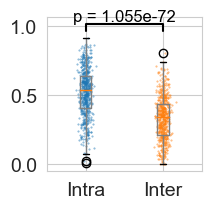

In [171]:
'''根据聚类结果计算簇内相似性与簇外相似性，做显著性检验'''
# 转换为一维数组，提取两两之间的相关系数
correlation_list = []
rows, cols = cosine_similarities.shape
for i in range(rows):
    for j in range(i + 1, cols):
        correlation_list.append(
            (cosine_similarities.index[i], cosine_similarities.columns[j], cosine_similarities.iat[i, j]))
# 转换为DataFrame并显示
correlation_df = pd.DataFrame(correlation_list, columns=['Node1', 'Node2', 'value'])

intra_corr = []
inter_corr = []
for i in range(1, 3):
    group1 = list(cosine_similarities_T[cosine_similarities_T["Cluster"]==i].index)
    filtered_df = correlation_df[correlation_df['Node1'].isin(group1) & correlation_df['Node2'].isin(group1)]
    intra_corr.extend(list(filtered_df['value']))  #簇内

    filtered_df1 = correlation_df[correlation_df['Node1'].isin(group1) & ~correlation_df['Node2'].isin(group1)]
    inter_corr.extend(list(filtered_df1['value']))     # 簇间

corr_list =  [intra_corr,inter_corr]
# 散点箱线图
# 设置图形大小
plt.figure(figsize=(2, 2))
# 创建箱线图
box = plt.boxplot(corr_list,boxprops=dict(color='grey'), whiskerprops=dict(color='grey'))
# 绘制散点图
for i, d in enumerate(corr_list, 1):
    y = d
    x = np.random.normal(i, 0.04, size=len(y))  # 在x轴位置上添加一些随机抖动
    plt.scatter(x, y, alpha=0.6,s = 0.2)

from scipy.stats import ttest_ind
# 计算 p 值
t_stat, p_value = ttest_ind(intra_corr, inter_corr)

# 在箱体之间添加标示线和 p 值
x1, x2 = 1, 2
y, h, col = max(max(intra_corr),max(inter_corr)) + 0.05, 0.05, 'k'
plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
plt.text((x1 + x2) * .5, y + h, f"p = {p_value:.3e}", ha='center', va='bottom', color=col, fontsize=12)

# 设置自定义横轴坐标值和标签
custom_ticks = [1, 2]  # 自定义的横轴坐标值
custom_labels = ["Intra","Inter"]  # 对应的标签
plt.xticks(custom_ticks, custom_labels)

In [29]:
'''根据组织特异性对组织进行聚类，并输出聚类结果'''
epsilon = 1e-10

core = "core"
# core = "peri"
traits_name = pd.read_excel(r"E:\00_CeSOP\data\49_traits.xlsx")
alltraits_significant = pd.DataFrame()
for trait in range(1,50):
    trait_name = traits_name[traits_name["Number"] == trait]["Trait name"].values[0]
    # trait_name = traits_name[traits_name["Number"] == trait]["Trait 名字"].values[0]
    df = pd.read_csv(r"E:\00_CeSOP\results\trait-cells-in-tissues-and-celltypes\tissues\%s\top10_%s_lcczscore.csv"%(trait,core))
    df = df.sort_values("tissue")  
    df["log fisher's pvalue"] = -np.log10(df["fisher's pvalue"] + + epsilon)
    alltraits_significant[trait_name] = df["log fisher's pvalue"]
alltraits_significant.index = df["tissue"]

## 将所有变量转换为中文



x = -np.log10(0.005 + epsilon)
cg = sns.clustermap(alltraits_significant, cmap='Greens', figsize=(12, 8), linewidths=0.01,
                    xticklabels=True, yticklabels=True,
                    method='complete', metric='cosine',
                    cbar_pos=(0.05, 0.87, 0.02, 0.1),
                    cbar_kws={'ticks': [0, x, 10]},
                    center=x)  #行是组织，列是性状
# plt.show()





# 计算每两列之间的余弦相似度
# 初始化一个空的 DataFrame 用于存储余弦相似度
alltraits_significant_T = alltraits_significant.T
cosine_similarities = pd.DataFrame(index=alltraits_significant_T.columns, columns=alltraits_significant_T.columns)
for col1 in alltraits_significant_T.columns:
    for col2 in alltraits_significant_T.columns:
        if col1 != col2:
            cosine_similarities.loc[col1, col2] = 1 - cosine(alltraits_significant_T[col1],
                                                             alltraits_significant_T[col2])
        else:
            cosine_similarities.loc[col1, col2] = 1  # 自身与自身的相似度为1

# 转换为数值类型
cosine_similarities = cosine_similarities.astype(float)
# 转换为一维数组，提取两两之间的相关系数
correlation_list = []
rows, cols = cosine_similarities.shape
for i in range(rows):
    for j in range(i + 1, cols):
        correlation_list.append(
            (cosine_similarities.index[i], cosine_similarities.columns[j], cosine_similarities.iat[i, j]))
# 转换为DataFrame并显示
correlation_df = pd.DataFrame(correlation_list, columns=['Node1', 'Node2', 'value'])
correlation_df.to_csv(r"E:\00_CeSOP\results\temp\cytoscape\tissues_cosine_similarity_for_tissues\edges.csv",index = None)

# 计算余弦距离矩阵
cosine_distance = pdist(alltraits_significant, metric='cosine')  # Transpose to calculate column distances
# 生成层次聚类
linkage_matrix = sch.linkage(cosine_distance, method='complete')
# 划分簇，设置簇数为3
# 划分簇，设置簇数为3
array = alltraits_significant.iloc[:, 0:-1].to_numpy()
# best_n_cluster = bestNclusters(linkage_matrix,array)
# print(best_n_cluster)
# cluster_assignments = sch.fcluster(linkage_matrix, t=best_n_cluster, criterion='maxclust')
cluster_assignments = sch.fcluster(linkage_matrix, t=2, criterion='maxclust')


# 添加簇分配结果到 DataFrame
alltraits_significant['Cluster'] = cluster_assignments
alltraits_significant['Cluster'].to_csv(r"E:\00_CeSOP\results\temp\cytoscape\tissues_cosine_similarity_for_tissues\nodes.csv")
from sklearn.metrics import silhouette_score

# 计算轮廓系数

sil_score = silhouette_score(array, cluster_assignments,metric="cosine")
print(f'Silhouette Score: {sil_score}')

from sklearn.metrics import calinski_harabasz_score
# 计算 CH 指数
ch_score = calinski_harabasz_score(array, cluster_assignments)
print(f'Calinski-Harabasz Score: {ch_score}')

NameError: name 'sns' is not defined

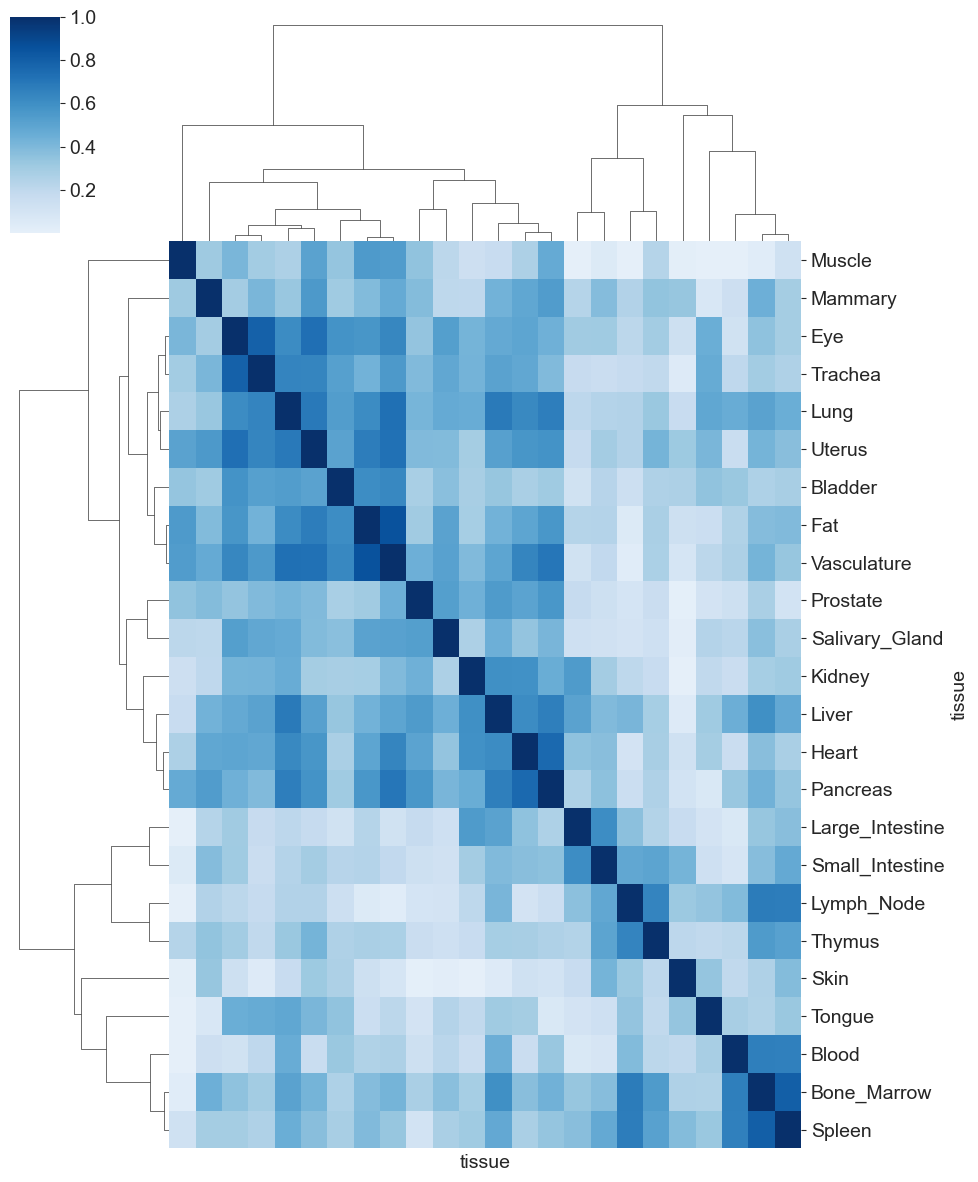

In [177]:
'''根据性状之间的相似性对组织进行重新聚类，组织之间的相似性是对组织特异性向量计算cosine相似性得到的'''
import seaborn as sns
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

epsilon = 1e-10
core = "core"
traits_name = pd.read_excel(r"E:\00_CeSOP\data\49_traits.xlsx")
alltraits_significant = pd.DataFrame()
for trait in range(1, 50):
    trait_name = traits_name[traits_name["Number"] == trait]["Trait name"].values[0]
    # trait_name = traits_name[traits_name["Number"] == trait]["Trait 名字"].values[0]
    df = pd.read_csv(
        r"E:\00_CeSOP\results\trait-cells-in-tissues-and-celltypes\tissues\%s\top10_%s_lcczscore.csv" % (trait, core))
    df = df.sort_values("tissue")
    df["log fisher's pvalue"] = -np.log10(df["fisher's pvalue"] + + epsilon)
    alltraits_significant[trait_name] = df["log fisher's pvalue"]
alltraits_significant.index = df["tissue"]
alltraits_significant_T = alltraits_significant.T

'''计算每两列(性状）之间的余弦相似度'''
cosine_similarities = pd.DataFrame(index=alltraits_significant_T.columns, columns=alltraits_significant_T.columns)
for col1 in alltraits_significant_T.columns:
    for col2 in alltraits_significant_T.columns:
        if col1 != col2:
            cosine_similarities.loc[col1, col2] = 1 - cosine(alltraits_significant_T[col1], alltraits_significant_T[col2])
        else:
            cosine_similarities.loc[col1, col2] = 1  # 自身与自身的相似度为1
# 转换为数值类型
cosine_similarities = cosine_similarities.astype(float)

# g = sns.clustermap(cosine_similarities, cmap='Blues', 
#                    figsize=(4, 4), linewidths=0,
#                    xticklabels=False, yticklabels=False,
#                    dendrogram_ratio=(0.001, 0.001),
#                    # method='average', metric='euclidean',
#                    # method='complete', metric='euclidean',
#                    method='complete', metric='cosine',
#                    cbar_pos=(1.01, 0.1, 0.05, 0.8),
#                    center=0.5)
g = sns.clustermap(cosine_similarities, cmap='Blues', figsize=(10, 12), linewidths=0,
                   xticklabels=False, yticklabels=True,
                   # method='average', metric='euclidean',
                   method='complete', metric='cosine',
                   center=0.45)

# cosine_similarities_T = cosine_similarities.T
# 
# '''提取聚类结果'''
# # 计算余弦距离矩阵
# cosine_distance = pdist(cosine_similarities_T, metric='euclidean')  # Transpose to calculate column distances
# # 生成层次聚类
# linkage_matrix = sch.linkage(cosine_distance, method='complete')
# # 划分簇，设置簇数为3
# array = cosine_similarities_T.iloc[:, 0:-1].to_numpy()
# cluster_assignments = sch.fcluster(linkage_matrix, t=2, criterion='maxclust')
# # 添加簇分配结果到 DataFrame
# cosine_similarities_T['Cluster'] = cluster_assignments
# cosine_similarities_T['Cluster'].to_csv(
#     r"E:\00_CeSOP\results\temp\cytoscape\traits_cosine_similarity_for_tissues\nodes1.csv")
# 
# '''计算轮廓系数'''
# from sklearn.metrics import silhouette_score
# sil_score = silhouette_score(array, cluster_assignments,metric="cosine")
# print(f'Silhouette Score: {sil_score}')
# 
# '''计算 CH 指数'''
# from sklearn.metrics import calinski_harabasz_score
# ch_score = calinski_harabasz_score(array, cluster_assignments)
# print(f'Calinski-Harabasz Score: {ch_score}')

No NaN or inf values in the data.
Silhouette Score: 0.12023653734928921
Calinski-Harabasz Score: 3.3637226771752955


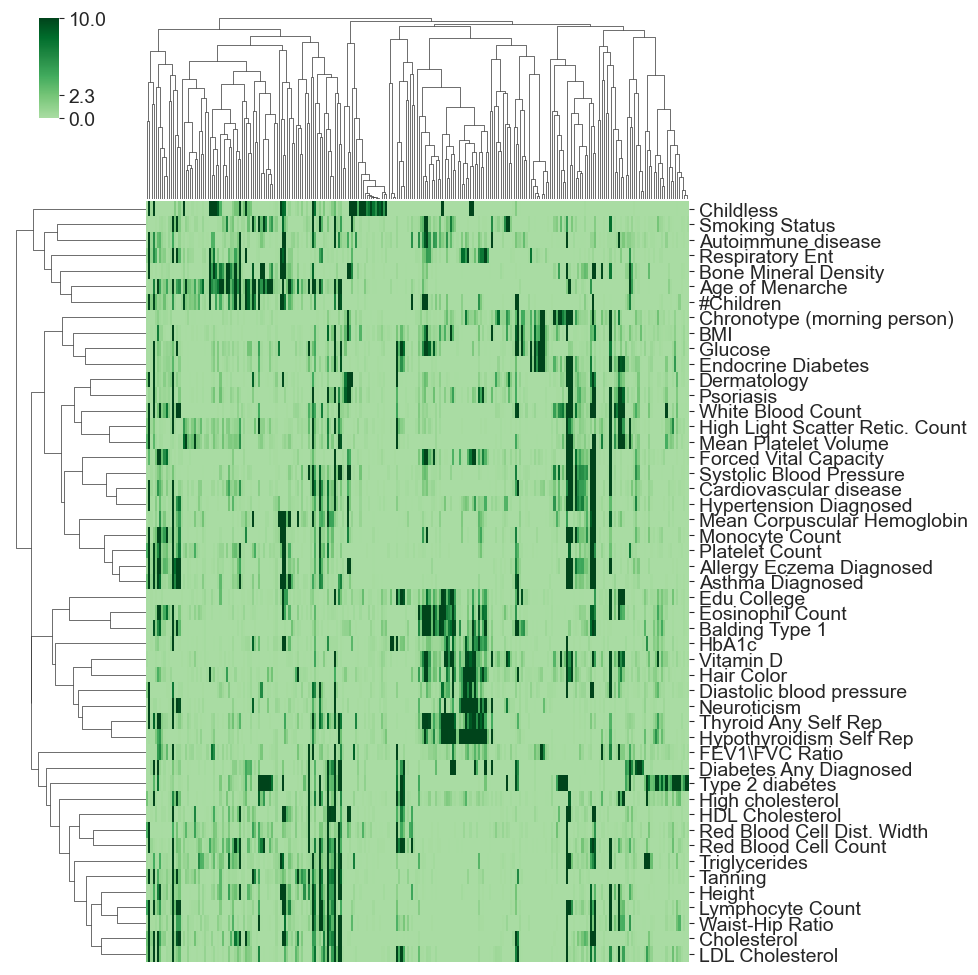

In [183]:
'''根据细胞类型特异性对性状进行聚类，并输出聚类结果'''

traits_name = pd.read_excel(r"E:\00_CeSOP\data\49_traits.xlsx")
alltraits_significant = pd.DataFrame()
for trait in range(1,50):
    trait_name = traits_name[traits_name["Number"] == trait]["Trait name"].values[0]
    # trait_name = traits_name[traits_name["Number"] == trait]["Trait 名字"].values[0]
    df = pd.read_csv(r"E:\00_CeSOP\results\trait-cells-in-tissues-and-celltypes\celltypes\%s\top10_%s_lcczscore.csv"%(trait,core))
    df = df.sort_values(["tissue","celltype"])  
    df["log fisher's pvalue"] = -np.log10(df["fisher's pvalue"] + + epsilon)
    alltraits_significant[trait_name] = df["log fisher's pvalue"]
alltraits_significant.index = df["tissue"] + "---" + df["celltype"]
# 处理NaN和inf值
alltraits_significant = alltraits_significant.replace([np.inf, -np.inf], np.nan).dropna()
# 检查是否有NaN或inf值
if alltraits_significant.isnull().values.any():
    print("Data contains NaN or inf values.")
else:
    print("No NaN or inf values in the data.")

'''层次聚类'''
alltraits_significant_T = alltraits_significant.T
x = -np.log10(0.005 + epsilon)
cg = sns.clustermap(alltraits_significant_T, cmap='Greens', 
                    yticklabels=True, xticklabels=False,
                    method='weighted', metric='correlation',
                    # method='complete', metric='cosine',
                    cbar_pos=(0.05, 0.87, 0.02, 0.1),
                    cbar_kws={'ticks': [0, x, 10]},
                    center=x)  #行是组织，列是性状
# plt.show()

'''计算每两列(性状）之间的余弦相似度'''
cosine_similarities = pd.DataFrame(index=alltraits_significant.columns, columns=alltraits_significant.columns)
for col1 in alltraits_significant.columns:
    for col2 in alltraits_significant.columns:
        if col1 != col2:
            cosine_similarities.loc[col1, col2] = 1 - cosine(alltraits_significant[col1], alltraits_significant[col2])
        else:
            cosine_similarities.loc[col1, col2] = 1  # 自身与自身的相似度为1
# 转换为数值类型
cosine_similarities = cosine_similarities.astype(float)
# 转换为一维数组，提取两两之间的相关系数
correlation_list = []
rows, cols = cosine_similarities.shape
for i in range(rows):
    for j in range(i + 1, cols):
        correlation_list.append(
            (cosine_similarities.index[i], cosine_similarities.columns[j], cosine_similarities.iat[i, j]))
# 转换为DataFrame并显示
correlation_df = pd.DataFrame(correlation_list, columns=['Node1', 'Node2', 'value'])
correlation_df.to_csv(r"E:\00_CeSOP\results\temp\cytoscape\traits_cosine_similarity_for_celltypes\edges.csv", index=None)

'''提取聚类结果'''
# 计算余弦距离矩阵
cosine_distance = pdist(alltraits_significant_T, metric='cosine')  # Transpose to calculate column distances
# 生成层次聚类
linkage_matrix = sch.linkage(cosine_distance, method='complete')
# 划分簇，设置簇数为3
array = alltraits_significant_T.iloc[:, 0:-1].to_numpy()
# best_n_cluster = bestNclusters(linkage_matrix,array)
# print(best_n_cluster)
# cluster_assignments = sch.fcluster(linkage_matrix, t=best_n_cluster, criterion='maxclust')
cluster_assignments = sch.fcluster(linkage_matrix, t=10, criterion='maxclust')
# 添加簇分配结果到 DataFrame
alltraits_significant_T['Cluster'] = cluster_assignments
alltraits_significant_T['Cluster'].to_csv(r"E:\00_CeSOP\results\temp\cytoscape\traits_cosine_similarity_for_celltypes\nodes.csv")

'''计算轮廓系数'''
from sklearn.metrics import silhouette_score
sil_score = silhouette_score(array, cluster_assignments,metric="cosine")
print(f'Silhouette Score: {sil_score}')

'''计算 CH 指数'''
from sklearn.metrics import calinski_harabasz_score
ch_score = calinski_harabasz_score(array, cluster_assignments)
print(f'Calinski-Harabasz Score: {ch_score}')

In [98]:
## 根据最大轮廓系数选择聚类簇
def bestNclusters1(linkage_matrix,array):
    ''' 
    :param linkage_matrix: 层次聚类矩阵
    :param array:  数据矩阵
    :return: 最优（最大轮廓系数）簇数
    '''
    # 计算不同簇数的轮廓系数
    silhouette_scores = {}
    for n_clusters in range(2, 100,5):  # 假设我们尝试从2到10个簇
        cluster_assignments = sch.fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')
        score = silhouette_score(array, cluster_assignments)
        silhouette_scores[n_clusters] = score
        print(f'Number of clusters: {n_clusters}, Silhouette Score: {score}')
    # 选择轮廓系数最高的簇数
    best_n_clusters = max(silhouette_scores, key=silhouette_scores.get)
    return best_n_clusters

No NaN or inf values in the data.


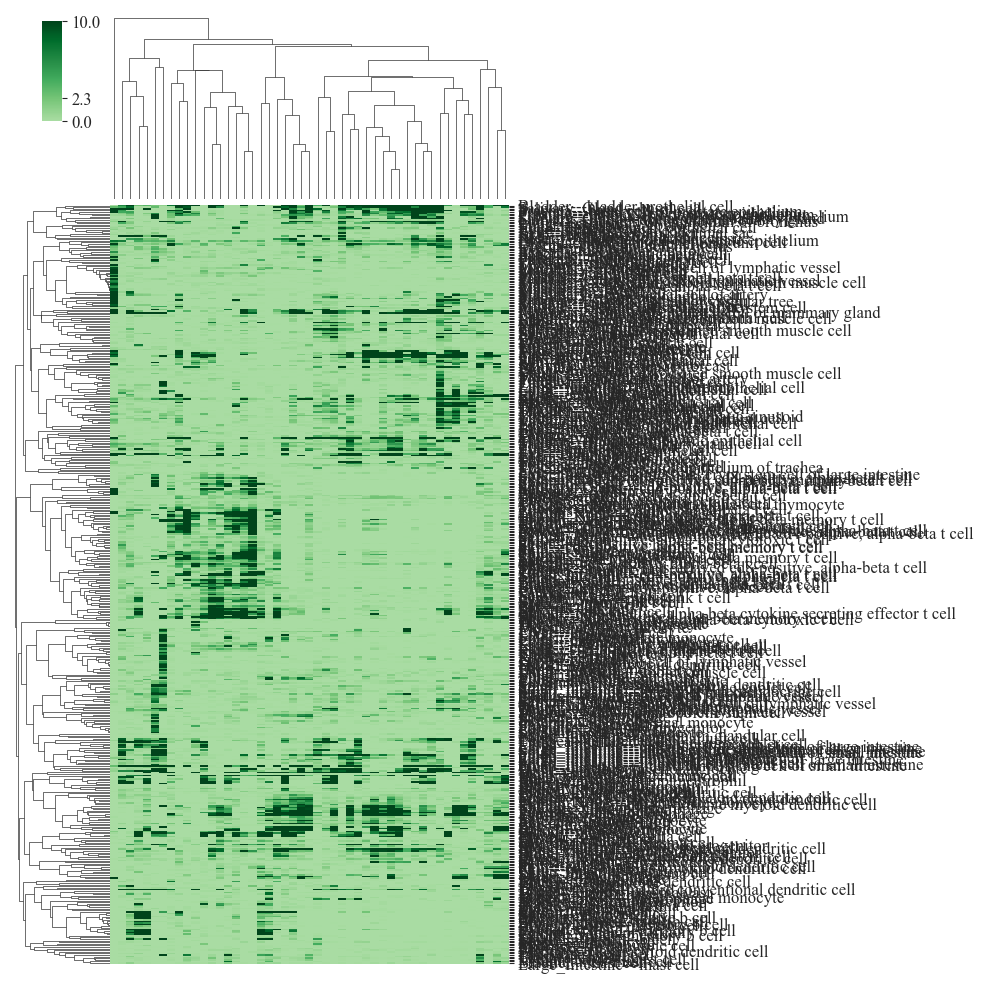

In [111]:
'''根据细胞类型特异性对性状进行聚类，并输出聚类结果'''

traits_name = pd.read_excel(r"E:\00_CeSOP\data\49_traits.xlsx")
alltraits_significant = pd.DataFrame()
for trait in range(1,50):
    trait_name = traits_name[traits_name["Number"] == trait]["Trait name"].values[0]
    # trait_name = traits_name[traits_name["Number"] == trait]["Trait 名字"].values[0]
    df = pd.read_csv(r"E:\00_CeSOP\results\trait-cells-in-tissues-and-celltypes\celltypes\%s\top10_%s_lcczscore.csv"%(trait,core))
    df = df.sort_values(["tissue","celltype"])  
    df["log fisher's pvalue"] = -np.log10(df["fisher's pvalue"] + + epsilon)
    alltraits_significant[trait_name] = df["log fisher's pvalue"]
alltraits_significant.index = df["tissue"] + "---" + df["celltype"]
# 处理NaN和inf值
alltraits_significant = alltraits_significant.replace([np.inf, -np.inf], np.nan).dropna()
# 检查是否有NaN或inf值
if alltraits_significant.isnull().values.any():
    print("Data contains NaN or inf values.")
else:
    print("No NaN or inf values in the data.")

'''层次聚类'''
alltraits_significant_T = alltraits_significant.T
x = -np.log10(0.005 + epsilon)
cg = sns.clustermap(alltraits_significant, cmap='Greens', 
                    yticklabels=True, xticklabels=False,
                    method='weighted', metric='correlation',
                    # method='complete', metric='cosine',
                    cbar_pos=(0.05, 0.87, 0.02, 0.1),
                    cbar_kws={'ticks': [0, x, 10]},
                    center=x)  #行是组织，列是性状
# plt.show()

'''计算每两列(性状）之间的余弦相似度'''
cosine_similarities = pd.DataFrame(index=alltraits_significant_T.columns, columns=alltraits_significant_T.columns)
for col1 in alltraits_significant_T.columns:
    for col2 in alltraits_significant_T.columns:
        if col1 != col2:
            cosine_similarities.loc[col1, col2] = 1 - cosine(alltraits_significant_T[col1], alltraits_significant_T[col2])
        else:
            cosine_similarities.loc[col1, col2] = 1  # 自身与自身的相似度为1
# 转换为数值类型
cosine_similarities = cosine_similarities.astype(float)
# 转换为一维数组，提取两两之间的相关系数
correlation_list = []
rows, cols = cosine_similarities.shape
for i in range(rows):
    for j in range(i + 1, cols):
        correlation_list.append(
            (cosine_similarities.index[i], cosine_similarities.columns[j], cosine_similarities.iat[i, j]))
# 转换为DataFrame并显示
correlation_df = pd.DataFrame(correlation_list, columns=['Node1', 'Node2', 'value'])
# correlation_df.to_csv(r"E:\00_CeSOP\results\temp\cytoscape\celltypes_cosine_similarity_for_celltypes\edges.csv", index=None)

'''提取聚类结果'''
# 计算余弦距离矩阵
cosine_distance = pdist(alltraits_significant, metric='cosine')  # Transpose to calculate column distances
# 生成层次聚类
linkage_matrix = sch.linkage(cosine_distance, method='complete')
# 划分簇，设置簇数为3
array = alltraits_significant.iloc[:, 0:-1].to_numpy()
# best_n_cluster = bestNclusters1(linkage_matrix,array)
# print(best_n_cluster)
# cluster_assignments = sch.fcluster(linkage_matrix, t=best_n_cluster, criterion='maxclust')
cluster_assignments = sch.fcluster(linkage_matrix, t=25, criterion='maxclust')
# 添加簇分配结果到 DataFrame
alltraits_significant['Cluster'] = cluster_assignments
# alltraits_significant['Cluster'].to_csv(r"E:\00_CeSOP\results\temp\cytoscape\celltypes_cosine_similarity_for_celltypes\nodes.csv")

In [112]:
alltraits_significant

Cholesterol       Glucose  \
Bladder---b cell                                7.899955e-06  2.592306e+00   
Bladder---bladder urothelial cell               1.000000e+01  2.606778e+00   
Bladder---capillary endothelial cell            4.090874e+00  5.169705e-01   
Bladder---endothelial cell of lymphatic vessel  3.010300e-01  1.469568e+00   
Bladder---fibroblast                           -4.342945e-11 -4.342945e-11   
...                                                      ...           ...   
Vasculature---nk cell                           3.773437e-05  1.640095e+00   
Vasculature---pericyte cell                     3.254250e+00 -4.342945e-11   
Vasculature---plasma cell                       1.913236e-01  1.370988e+00   
Vasculature---smooth muscle cell                1.847642e-04 -4.342945e-11   
Vasculature---t cell                            1.426142e-08  4.782914e-02   

                                                       HbA1c  HDL Cholesterol  \
Bladder---b cell                                2.280409e-02     5.940269e-03   
Bladder---bladder urothelial cell               1.000000e+01     1.000000e+01   
Bladder---capillary endothelial cell            2.179513e-02     2.530705e+00   
Bladder---endothelial cell of lymphatic vessel  4.022497e-01     9.416862e-01   
Bladder---fibroblast                            8.487795e+00     2.115114e+00   
...                                                      ...              ...   
Vasculature---nk cell                           5.628597e-01     1.253623e-03   
Vasculature---pericyte cell                     1.389493e-03     5.592506e+00   
Vasculature---plasma cell                       4.614430e-02     1.058532e-01   
Vasculature---smooth muscle cell               -4.342945e-11    -3.223920e-11   
Vasculature---t cell                            2.036582e+00     7.041345e-05   

                                                LDL Cholesterol  \
Bladder---b cell                                   2.280409e-02   
Bladder---bladder urothelial cell                  9.999991e+00   
Bladder---capillary endothelial cell               2.076775e+00   
Bladder---endothelial cell of lymphatic vessel     3.010300e-01   
Bladder---fibroblast                              -4.342945e-11   
...                                                         ...   
Vasculature---nk cell                              3.386904e-02   
Vasculature---pericyte cell                        3.506900e-01   
Vasculature---plasma cell                          4.330263e-01   
Vasculature---smooth muscle cell                   2.816579e-03   
Vasculature---t cell                               4.924348e-03   

                                                Triglycerides     Vitamin D  \
Bladder---b cell                                     0.005940  9.724824e-03   
Bladder---bladder urothelial cell                   10.000000  3.320758e-10   
Bladder---capillary endothelial cell                 1.463333  1.403478e-03   
Bladder---endothelial cell of lymphatic vessel       0.941686  2.168829e-02   
Bladder---fibroblast                                 0.543659 -4.342945e-11   
...                                                       ...           ...   
Vasculature---nk cell                                0.232918  1.176865e+00   
Vasculature---pericyte cell                          3.808646  1.712177e+00   
Vasculature---plasma cell                            0.046144  1.058532e-01   
Vasculature---smooth muscle cell                    10.000000  1.767088e-01   
Vasculature---t cell                                 0.006963  2.595751e+00   

                                                Eosinophil Count  \
Bladder---b cell                                        0.046176   
Bladder---bladder urothelial cell                       9.999821   
Bladder---capillary endothelial cell                    0.088317   
Bladder---endothelial cell of lymphatic vessel          0.047852   
Bladder---fibroblast                         

No NaN or inf values in the data.
Silhouette Score: -0.19386442910889012
Calinski-Harabasz Score: 5.470824840059626


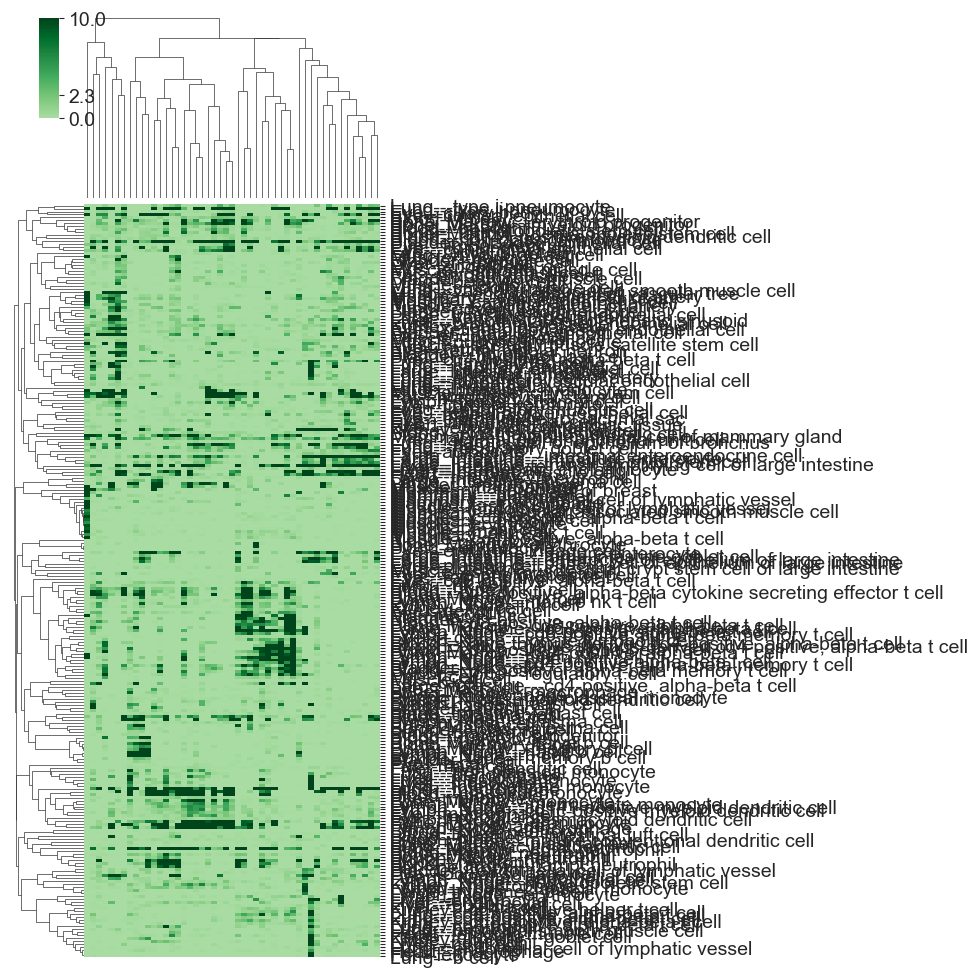

In [4]:
'''根据细胞类型特异性对性状进行聚类，并输出聚类结果'''

traits_name = pd.read_excel(r"E:\00_CeSOP\data\49_traits.xlsx")
alltraits_significant = pd.DataFrame()
for trait in range(1,50):
    trait_name = traits_name[traits_name["Number"] == trait]["Trait name"].values[0]
    # trait_name = traits_name[traits_name["Number"] == trait]["Trait 名字"].values[0]
    df = pd.read_csv(r"E:\00_CeSOP\results\trait-cells-in-tissues-and-celltypes\celltypes\%s\top10_%s_lcczscore.csv"%(trait,core))
    df = df.sort_values(["tissue","celltype"])  
    df["log fisher's pvalue"] = -np.log10(df["fisher's pvalue"] + + epsilon)
    alltraits_significant[trait_name] = df["log fisher's pvalue"]
alltraits_significant.index = df["tissue"] + "---" + df["celltype"]
# 处理NaN和inf值
alltraits_significant = alltraits_significant.replace([np.inf, -np.inf], np.nan).dropna()
# 检查是否有NaN或inf值
if alltraits_significant.isnull().values.any():
    print("Data contains NaN or inf values.")
else:
    print("No NaN or inf values in the data.")

'''层次聚类'''
alltraits_significant_T = alltraits_significant.T
x = -np.log10(0.005 + epsilon)
cg = sns.clustermap(alltraits_significant, cmap='Greens', 
                    yticklabels=True, xticklabels=False,
                    method='weighted', metric='correlation',
                    # method='complete', metric='cosine',
                    cbar_pos=(0.05, 0.87, 0.02, 0.1),
                    cbar_kws={'ticks': [0, x, 10]},
                    center=x)  #行是组织，列是性状
# plt.show()

'''计算每两列(性状）之间的余弦相似度'''
cosine_similarities = pd.DataFrame(index=alltraits_significant_T.columns, columns=alltraits_significant_T.columns)
for col1 in alltraits_significant_T.columns:
    for col2 in alltraits_significant_T.columns:
        if col1 != col2:
            cosine_similarities.loc[col1, col2] = 1 - cosine(alltraits_significant_T[col1], alltraits_significant_T[col2])
        else:
            cosine_similarities.loc[col1, col2] = 1  # 自身与自身的相似度为1
# 转换为数值类型
cosine_similarities = cosine_similarities.astype(float)
# 转换为一维数组，提取两两之间的相关系数
correlation_list = []
rows, cols = cosine_similarities.shape
for i in range(rows):
    for j in range(i + 1, cols):
        correlation_list.append(
            (cosine_similarities.index[i], cosine_similarities.columns[j], cosine_similarities.iat[i, j]))
# 转换为DataFrame并显示
correlation_df = pd.DataFrame(correlation_list, columns=['Node1', 'Node2', 'value'])
correlation_df.to_csv(r"E:\00_CeSOP\results\temp\cytoscape\celltypes_cosine_similarity_for_celltypes\edges.csv", index=None)

'''提取聚类结果'''
# 计算余弦距离矩阵
cosine_distance = pdist(alltraits_significant, metric='cosine')  # Transpose to calculate column distances
# 生成层次聚类
linkage_matrix = sch.linkage(cosine_distance, method='complete')
# 划分簇，设置簇数为3
array = alltraits_significant.iloc[:, 0:-1].to_numpy()
# best_n_cluster = bestNclusters1(linkage_matrix,array)
# print(best_n_cluster)
# cluster_assignments = sch.fcluster(linkage_matrix, t=best_n_cluster, criterion='maxclust')
cluster_assignments = sch.fcluster(linkage_matrix, t=25, criterion='maxclust')
# 添加簇分配结果到 DataFrame
alltraits_significant['Cluster'] = cluster_assignments
alltraits_significant['Cluster'].to_csv(r"E:\00_CeSOP\results\temp\cytoscape\celltypes_cosine_similarity_for_celltypes\nodes.csv")

'''计算轮廓系数'''
from sklearn.metrics import silhouette_score
sil_score = silhouette_score(array, cluster_assignments)
print(f'Silhouette Score: {sil_score}')

'''计算 CH 指数'''
from sklearn.metrics import calinski_harabasz_score
ch_score = calinski_harabasz_score(array, cluster_assignments)
print(f'Calinski-Harabasz Score: {ch_score}')

No NaN or inf values in the data.


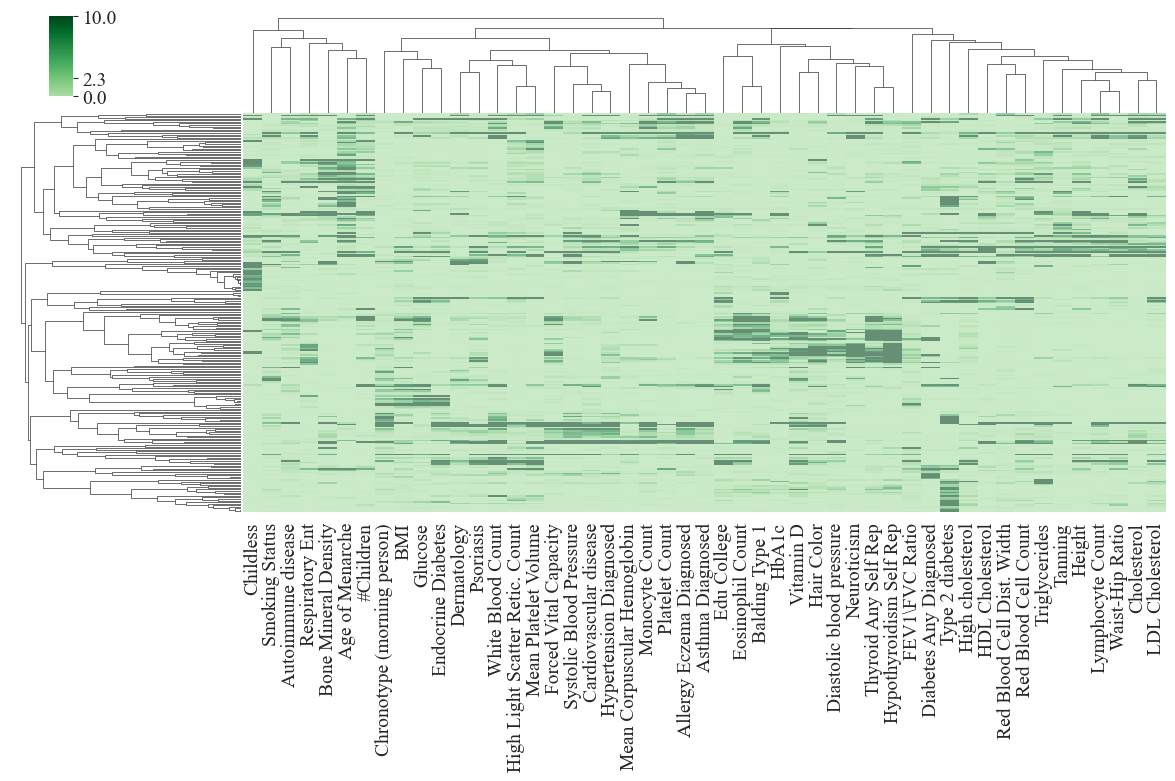

In [80]:
## 细胞类型
import matplotlib as mpl
# 设置中文字体
# mpl.rcParams['font.sans-serif'] = ['SimHei']
# # 设置英文字体为 Times New Roman
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman']
epsilon = 1e-10
core = "core"
# core = "peri"
traits_name = pd.read_excel(r"E:\00_CeSOP\data\49_traits.xlsx")
alltraits_significant = pd.DataFrame()
for trait in range(1,50):
    trait_name = traits_name[traits_name["Number"] == trait]["Trait name"].values[0]
    # trait_name = traits_name[traits_name["Number"] == trait]["Trait 名字"].values[0]
    df = pd.read_csv(r"E:\00_CeSOP\results\trait-cells-in-tissues-and-celltypes\celltypes\%s\top10_%s_lcczscore.csv"%(trait,core))
    df = df.sort_values(["tissue","celltype"])  
    df["log fisher's pvalue"] = -np.log10(df["fisher's pvalue"] + + epsilon)
    alltraits_significant[trait_name] = df["log fisher's pvalue"]
alltraits_significant.index = df["tissue"] + "---" + df["celltype"]
# 处理NaN和inf值
alltraits_significant = alltraits_significant.replace([np.inf, -np.inf], np.nan).dropna()
# 检查是否有NaN或inf值
if alltraits_significant.isnull().values.any():
    print("Data contains NaN or inf values.")
else:
    print("No NaN or inf values in the data.")

x = -np.log10(0.005 + epsilon)
cg = sns.clustermap(alltraits_significant, cmap='Greens', 
                    figsize=(12, 8),  linewidths = 0.002,
                    xticklabels=True ,  yticklabels=False,
                    method='weighted', metric='correlation',
                   # method='complete', metric='cosine',
                   cbar_pos=(0.05, 0.87, 0.02, 0.1),
                   cbar_kws={'ticks':[0,x,10]},
                   center=x)  #行是组织，列是性状
# 调整透明度
cg.ax_heatmap.collections[0].set_alpha(0.6)  # 设置透明度为 0.5
plt.show()

No NaN or inf values in the data.


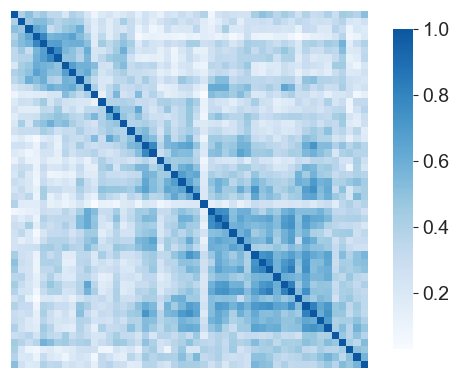

In [5]:
'''根据细胞类型特异性对性状进行聚类，并输出聚类结果'''

traits_name = pd.read_excel(r"E:\00_CeSOP\data\49_traits.xlsx")
alltraits_significant = pd.DataFrame()
## 只列出37个性状
for trait in range(1,50):
    trait_name = traits_name[traits_name["Number"] == trait]["Trait name"].values[0]
    df = pd.read_csv(r"E:\00_CeSOP\results\trait-cells-in-tissues-and-celltypes\celltypes\%s\top10_%s_lcczscore.csv"%(trait,core))
    df = df.sort_values(["tissue","celltype"])  
    df["log fisher's pvalue"] = -np.log10(df["fisher's pvalue"] + + epsilon)
    alltraits_significant[trait_name] = df["log fisher's pvalue"]
alltraits_significant.index = df["tissue"] + "---" + df["celltype"]
# 处理NaN和inf值
alltraits_significant = alltraits_significant.replace([np.inf, -np.inf], np.nan).dropna()
# 检查是否有NaN或inf值
if alltraits_significant.isnull().values.any():
    print("Data contains NaN or inf values.")
else:
    print("No NaN or inf values in the data.")

'''层次聚类'''
alltraits_significant_T = alltraits_significant.T
x = -np.log10(0.005 + epsilon)
# cg = sns.clustermap(alltraits_significant_T, cmap='Greens', 
#                     yticklabels=True, xticklabels=False,
#                     method='weighted', metric='correlation',
#                     # method='complete', metric='cosine',
#                     cbar_pos=(0.05, 0.87, 0.02, 0.1),
#                     cbar_kws={'ticks': [0, x, 10]},
#                     center=x)  #行是组织，列是性状

'''计算每两列(性状）之间的余弦相似度'''
cosine_similarities = pd.DataFrame(index=alltraits_significant.columns, columns=alltraits_significant.columns)
for col1 in alltraits_significant.columns:
    for col2 in alltraits_significant.columns:
        if col1 != col2:
            cosine_similarities.loc[col1, col2] = 1 - cosine(alltraits_significant[col1], alltraits_significant[col2])
        else:
            cosine_similarities.loc[col1, col2] = 1  # 自身与自身的相似度为1

# 转换为数值类型
cosine_similarities = cosine_similarities.astype(float)
g = sns.clustermap(cosine_similarities, cmap='Blues', 
                   figsize=(4, 4), linewidths=0,
                   xticklabels=False, yticklabels=False,
                   dendrogram_ratio=(0.001, 0.001),
                   method='complete', metric='cosine',
                   cbar_pos=(1.01, 0.1, 0.05, 0.8),
                   center=0.6)
cosine_similarities_list = []
rows, cols = cosine_similarities.shape
for i in range(rows):
    for j in range(i + 1, cols):
        rows, cols = cosine_similarities.shape
        cosine_similarities_list.append(
            (cosine_similarities.index[i], cosine_similarities.columns[j], cosine_similarities.iat[i, j]))
# 转换为DataFrame并显示
cosine_similarities_df = pd.DataFrame(cosine_similarities_list, columns=['Node1', 'Node2', 'value'])
# cosine_similarities_df.to_csv(r"E:\00_CeSOP\results\ldsc_rg\cesop\celltypes\edges.csv",index = None)

In [71]:
# 计算每两列之间的余弦相似度
# 初始化一个空的 DataFrame 用于存储余弦相似度
alltraits_significant_T = alltraits_significant.T
cosine_similarities = pd.DataFrame(index=alltraits_significant_T.columns, columns=alltraits_significant_T.columns)
for col1 in alltraits_significant_T.columns:
    for col2 in alltraits_significant_T.columns:
        if col1 != col2:
            cosine_similarities.loc[col1, col2] = 1 - cosine(alltraits_significant_T[col1], alltraits_significant_T[col2])
        else:
            cosine_similarities.loc[col1, col2] = 1  # 自身与自身的相似度为1

# 转换为数值类型
cosine_similarities = cosine_similarities.astype(float)
# 转换为一维数组，提取两两之间的相关系数
correlation_list = []
rows, cols = cosine_similarities.shape
for i in range(rows):
    for j in range(i + 1, cols):
        correlation_list.append((cosine_similarities.index[i], cosine_similarities.columns[j], cosine_similarities.iat[i, j]))
# 转换为DataFrame并显示
correlation_df = pd.DataFrame(correlation_list, columns=['Node1', 'Node2', 'value'])
# correlation_df.to_csv(r"E:\00_CeSOP\results\temp\cytoscape\traits_cosine_similarity_for_tissues\edges.csv",index = None)


In [55]:
# 计算余弦距离矩阵
cosine_distance = pdist(alltraits_significant, metric='cosine')  # Transpose to calculate column distances
# 生成层次聚类
linkage_matrix = sch.linkage(cosine_distance, method='complete')
# 划分簇，设置簇数为3
cluster_assignments = sch.fcluster(linkage_matrix, t=4, criterion='maxclust')

# 添加簇分配结果到 DataFrame
alltraits_significant['Cluster'] = cluster_assignments
# clustered_columns.to_csv(r"E:\00_CeSOP\results\temp\cytoscape\traits_cosine_similarity_for_tissues\nodes.csv",index = None)

In [57]:
from sklearn.metrics import silhouette_score
# 计算轮廓系数
array = alltraits_significant.iloc[:,0:-1].to_numpy()
sil_score = silhouette_score(array, cluster_assignments)
print(f'Silhouette Score: {sil_score}')

from sklearn.metrics import calinski_harabasz_score
# 计算 CH 指数
ch_score = calinski_harabasz_score(array, cluster_assignments)
print(f'Calinski-Harabasz Score: {ch_score}')

Silhouette Score: 0.018141089911363734
Calinski-Harabasz Score: 2.5803116834097386


#### 对外围结果的解释

In [112]:
def jaccard_similarity(set1, set2):
    """计算两个集合之间的 Jaccard 系数"""
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union

In [115]:
# 49个性状的外围基因在单细胞中的表达
## 单细胞基因
annData = sc.read_h5ad(r"E:\00_CeSOP\data\TS_FACS\TS_Liver.h5ad")
sc_gene = list(annData.var.index)
all_perigene = []
for t in range(1,50):
    ## 性状外围基因
    trait_perigene = list(pd.read_csv(r"E:\00_CeSOP\data\core_peri_geneset_of_49_traits\periphery_lcc\%s.txt"%t,sep = "\t",header= None)[0])
    trait_perigene_set = list(set(trait_perigene) & set(sc_gene))
    ## 49个性状的外围基因的一致性
    all_perigene.append(trait_perigene_set)

# 计算两两集合之间的 Jaccard 系数
jaccard_matrix = []

for i in range(len(all_perigene)):
    row = []
    for j in range(len(all_perigene)):
        if i == j:
            row.append(1.0)  # 自己与自己比较的 Jaccard 系数为 1
        else:
            jaccard_index = jaccard_similarity(set(all_perigene[i]), set(all_perigene[j]))
            row.append(jaccard_index)
    jaccard_matrix.append(row)
jaccard_matrix_df = pd.DataFrame(jaccard_matrix)
traits_name = pd.read_excel(r"E:\00_CeSOP\data\49_traits.xlsx")
traits_name_list = list(traits_name["Trait name"])
jaccard_matrix_df.index = traits_name_list
jaccard_matrix_df.columns = traits_name_list


0         1         2         3         4         5         6   \
0   1.000000  0.194450  0.199626  0.216653  0.483007  0.221753  0.182993   
1   0.194450  1.000000  0.305085  0.290412  0.222202  0.282616  0.278076   
2   0.199626  0.305085  1.000000  0.280694  0.223090  0.289400  0.238592   
3   0.216653  0.290412  0.280694  1.000000  0.251176  0.351463  0.283320   
4   0.483007  0.222202  0.223090  0.251176  1.000000  0.257091  0.217566   
5   0.221753  0.282616  0.289400  0.351463  0.257091  1.000000  0.269688   
6   0.182993  0.278076  0.238592  0.283320  0.217566  0.269688  1.000000   
7   0.151495  0.166165  0.173475  0.160417  0.140938  0.156713  0.139146   
8   0.199137  0.275371  0.288388  0.345638  0.248598  0.326255  0.270583   
9   0.195056  0.228128  0.259343  0.241176  0.196524  0.233962  0.198503   
10  0.181366  0.200500  0.225355  0.241812  0.190370  0.220745  0.199581   
11  0.169331  0.222056  0.236948  0.262123  0.191321  0.235582  0.200436   
12  0.186638  0.219044  0.240124  0.227864  0.192046  0.220853  0.194238   
13  0.198259  0.205150  0.243699  0.224470  0.185413  0.227263  0.185805   
14  0.181688  0.179186  0.224766  0.195180  0.182861  0.194771  0.158627   
15  0.205557  0.244587  0.269764  0.284308  0.224334  0.261682  0.232328   
16  0.212600  0.272611  0.277561  0.301700  0.223214  0.286020  0.250951   
17  0.188640  0.239910  0.245391  0.246813  0.188845  0.251137  0.222222   
18  0.200640  0.337880  0.283592  0.342675  0.250040  0.305381  0.320375   
19  0.193615  0.323352  0.285313  0.336216  0.224573  0.296622  0.281204   
20  0.181023  0.240818  0.228055  0.229547  0.187287  0.237271  0.206795   
21  0.180756  0.269150  0.257223  0.284012  0.204332  0.291099  0.245758   
22  0.205672  0.307707  0.283327  0.315844  0.232383  0.286667  0.266315   
23  0.202111  0.290383  0.261126  0.262661  0.208924  0.262311  0.245914   
24  0.193608  0.300705  0.250699  0.279573  0.208037  0.272577  0.271471   
25  0.158922  0.260603  0.221883  0.258699  0.190132  0.242862  0.250127   
26  0.145555  0.221928  0.210422  0.228512  0.174557  0.215768  0.210760   
27  0.166421  0.242468  0.221906  0.310241  0.221892  0.249903  0.251154   
28  0.176029  0.218000  0.214446  0.236977  0.201767  0.224709  0.215905   
29  0.199205  0.290424  0.269552  0.329039  0.239502  0.298094  0.278584   
30  0.172079  0.248510  0.212689  0.212857  0.180860  0.212335  0.213147   
31  0.172773  0.311529  0.283938  0.305479  0.219392  0.258534  0.283593   
32  0.173412  0.282696  0.264268  0.240237  0.193562  0.231994  0.235424   
33  0.164131  0.224436  0.204050  0.288546  0.229551  0.251052  0.242395   
34  0.192368  0.265448  0.255395  0.255770  0.206823  0.252188  0.226652   
35  0.169532  0.300375  0.249533  0.345467  0.233206  0.286971  0.301700   
36  0.173254  0.206997  0.197044  0.225762  0.203498  0.200926  0.203133   
37  0.185049  0.316746  0.294453  0.285569  0.223665  0.271130  0.275265   
38  0.158751  0.220500  0.195243  0.215984  0.173048  0.203700  0.199229   
39  0.198681  0.325039  0.290494  0.324951  0.237845  0.308567  0.296997   
40  0.192895  0.284222  0.266547  0.254889  0.203401  0.258090  0.241920   
41  0.179633  0.316534  0.266538  0.351421  0.236398  0.307784  0.312428   
42  0.175775  0.294804  0.255610  0.311343  0.222886  0.275962  0.281901   
43  0.142994  0.180495  0.189781  0.199911  0.169283  0.195855  0.181396   
44  0.125498  0.165180  0.156468  0.187849  0.152857  0.173450  0.174544   
45  0.152461  0.216331  0.195055  0.209181  0.160868  0.204276  0.209666   
46  0.197415  0.323705  0.279650  0.328519  0.235275  0.302748  0.305054   
47  0.158057  0.236833  0.204525  0.256521  0.195414  0.215211  0.232772   
48  0.158341  0.257662  0.227542  0.313548  0.205928  0.251232  0.259992   

          7         8         9   ...        39        40        41        42  \
0   0.151495  0.199137  0.195056  ...  0.198681  0.192895  0.179633  0.175775   
1   0.166165  0.275371  0.228128  ...  0.325039

## 49个性状结果分析
### 统计——每个性状显著相关的组织、细胞类型数量分布


In [33]:
core = "core"
# core = "peri"
traits_name = pd.read_excel(r"E:\00_CeSOP\data\49_traits.xlsx")
alltraits_significant = pd.DataFrame()
for trait in range(1,50):
    # print(trait)
    trait_name = traits_name[traits_name["Number"] == trait]["Trait name"].values[0]
    # trait_name = traits_name[traits_name["Number"] == trait]["Trait 名字"].values[0]
    df = pd.read_csv(r"E:\00_CeSOP\results\trait-cells-in-tissues-and-celltypes\tissues\%s\top10_%s_lcczscore.csv"%(trait,core))
    df = df.sort_values("tissue")  
    # 创建新列 'a'，根据 'col1' 列的值设置
    df['a'] = df["fisher's pvalue"] > 0.005
    # 将 True 和 False 转换为字符串 'true' 和 'false'
    df['a'] = df['a'].map({True: 0, False: 1})
    alltraits_significant[trait_name] = df['a']
alltraits_significant.index = df["tissue"]
alltraits_significant.to_csv(r"E:\00_CeSOP\results\alltraits_significant_yesorno_tissues_peri.csv")

In [12]:
core = "core"
# core = "peri"
traits_name = pd.read_excel(r"E:\00_CeSOP\data\49_traits.xlsx")
alltraits_significant = pd.DataFrame()

trait=29
# print(trait)
trait_name = traits_name[traits_name["Number"] == trait]["Trait name"].values[0]
# trait_name = traits_name[traits_name["Number"] == trait]["Trait 名字"].values[0]
df = pd.read_csv(r"E:\00_CeSOP\results\trait-cells-in-tissues-and-celltypes\celltypes\%s\top10_%s_lcczscore.csv"%(trait,core))

In [13]:
df.sort_values("fisher's pvalue")

Unnamed: 0           tissue                                     celltype  \
465         465      Vasculature                                   fibroblast   
187         187             Lung                           type ii pneumocyte   
1             1          Bladder                      bladder urothelial cell   
65           65              Eye                      corneal epithelial cell   
93           93              Fat                                   fibroblast   
..          ...              ...                                          ...   
398         398           Thymus                                    mast cell   
396         396           Thymus                         innate lymphoid cell   
159         159             Lung               cd4-positive alpha-beta t cell   
337         337  Small_Intestine              cd4-positive, alpha-beta t cell   
120         120  Large_Intestine  enterocyte of epithelium of large intestine   

     cellnum  relatedCellnum   jaccard  fisher's pvalue  hypergeom pvalue  
465     5867            2076  0.353844    1.145736e-247      0.000000e+00  
187     9146            2572  0.281216    4.162246e-221      0.000000e+00  
1       4151            1317  0.317273    2.214581e-136      0.000000e+00  
65      1488             711  0.477823    4.289828e-122     3.369413e-303  
93      8459            1827  0.215983     3.433487e-97     5.110817e-221  
..       ...             ...       ...              ...               ...  
398       11               0  0.000000     1.000000e+00      1.000000e+00  
396     2594              89  0.034310     1.000000e+00      1.000000e+00  
159      132               0  0.000000     1.000000e+00      1.000000e+00  
337     5257              42  0.007989     1.000000e+00      1.000000e+00  
120     2764              46  0.016643     1.000000e+00      1.000000e+00  

[474 rows x 8 columns]

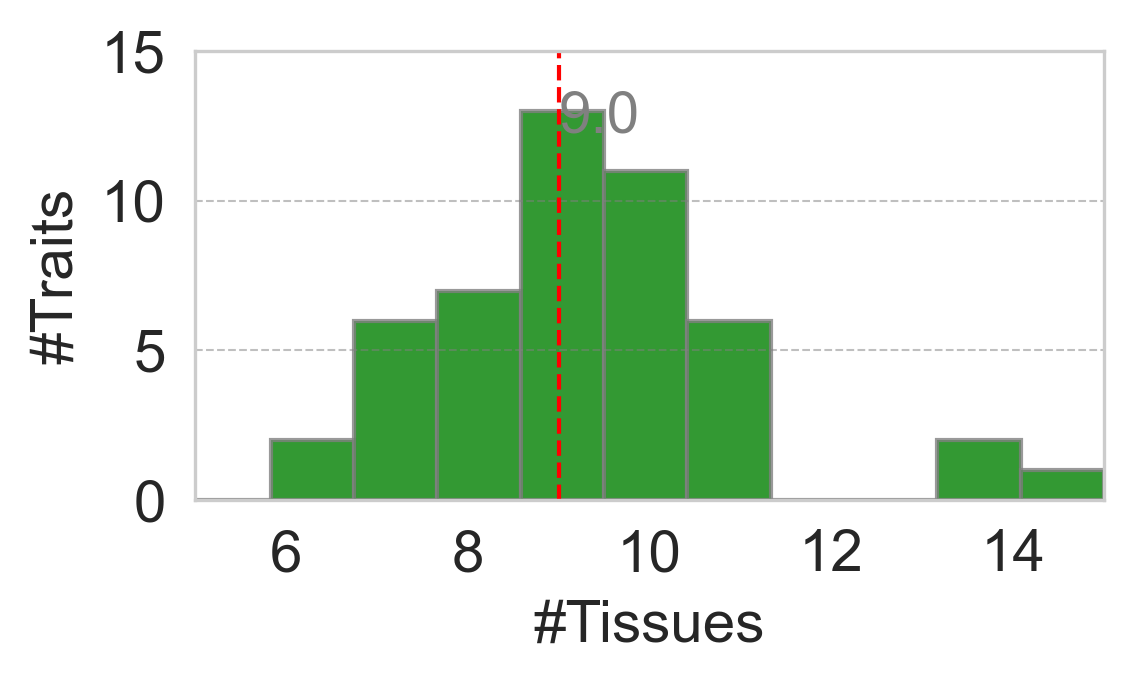

In [7]:
# 每个性状显著相关的组织数量分布
alltraits_significant_core = pd.read_csv(r"E:\00_CeSOP\results\alltraits_significant_yesorno_tissues_core.csv")
core_tissue_num = alltraits_significant_core.sum().values[1:]
# 计算数据的均值
mean_value = np.mean(core_tissue_num)
plt.figure(figsize=(4,2.5),dpi = 300)
plt.axhline(y=5, color='grey', linestyle='--',alpha=0.5,linewidth=0.5)
plt.axhline(y=10, color='grey', linestyle='--',alpha=0.5,linewidth=0.5)
plt.hist(core_tissue_num,  bins=12, color='green',alpha = 0.8,edgecolor='grey')
# 在x轴上绘制表示均值的竖线
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=1)
# 添加注释来标识均值
plt.text(mean_value, plt.ylim()[1]*0.9, f'{mean_value:.1f}', color='grey')
plt.xlim(5,15)
plt.ylim(0,15)
plt.xlabel("#Tissues")
plt.ylabel("#Traits")
plt.grid(False)
# 自动调整子图间的间距
plt.tight_layout()
plt.savefig(r"E:\00_CeSOP\results\figures\1.jpg",)
plt.show()
# 
# alltraits_significant_peri = pd.read_csv(r"E:\00_CeSOP\results\alltraits_significant_yesorno_tissues_peri.csv")
# peri_tissue_num = alltraits_significant_peri.sum().values[1:]
# # 计算数据的均值
# mean_value = np.mean(peri_tissue_num)
# plt.figure(figsize=(4,2.5))
# plt.axhline(y=5, color='grey', linestyle='--',alpha=0.5,linewidth=0.5)
# plt.axhline(y=10, color='grey', linestyle='--',alpha=0.5,linewidth=0.5)
# plt.hist(peri_tissue_num, bins= 9, color='green',alpha = 0.3, edgecolor='grey')
# # 在x轴上绘制表示均值的竖线
# plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=1)
# # 添加注释来标识均值
# plt.text(mean_value, plt.ylim()[1]*0.9, f'{mean_value:.1f}', color='grey')
# plt.xlim(5,15)
# plt.xlabel("#Tissues")
# plt.ylabel("#Traits")
# plt.grid(False)
# plt.show()


In [ ]:
### 细胞类型

In [34]:
# core = "core"
core = "peri"
traits_name = pd.read_excel(r"E:\00_CeSOP\data\49_traits.xlsx")
alltraits_significant = pd.DataFrame()

for trait in range(1,50):
    trait_name = traits_name[traits_name["Number"] == trait]["Trait name"].values[0]
    # trait_name = traits_name[traits_name["Number"] == trait]["Trait 名字"].values[0]
    df = pd.read_csv(r"E:\00_CeSOP\results\trait-cells-in-tissues-and-celltypes\celltypes\%s\top10_%s_lcczscore.csv"%(trait,core))
    df = df.sort_values(["tissue","celltype"])  
    # 创建新列 'a'，根据 'col1' 列的值设置
    df['a'] = df["fisher's pvalue"] > 0.005
    # 将 True 和 False 转换为字符串 'true' 和 'false'
    df['a'] = df['a'].map({True: 0, False: 1})
    alltraits_significant[trait_name] = df['a']
alltraits_significant["tissue"] = df["tissue"]
alltraits_significant["celltype"] = df["celltype"]
alltraits_significant.to_csv(r"E:\00_CeSOP\results\alltraits_significant_yesorno_celltypes_peri.csv")

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


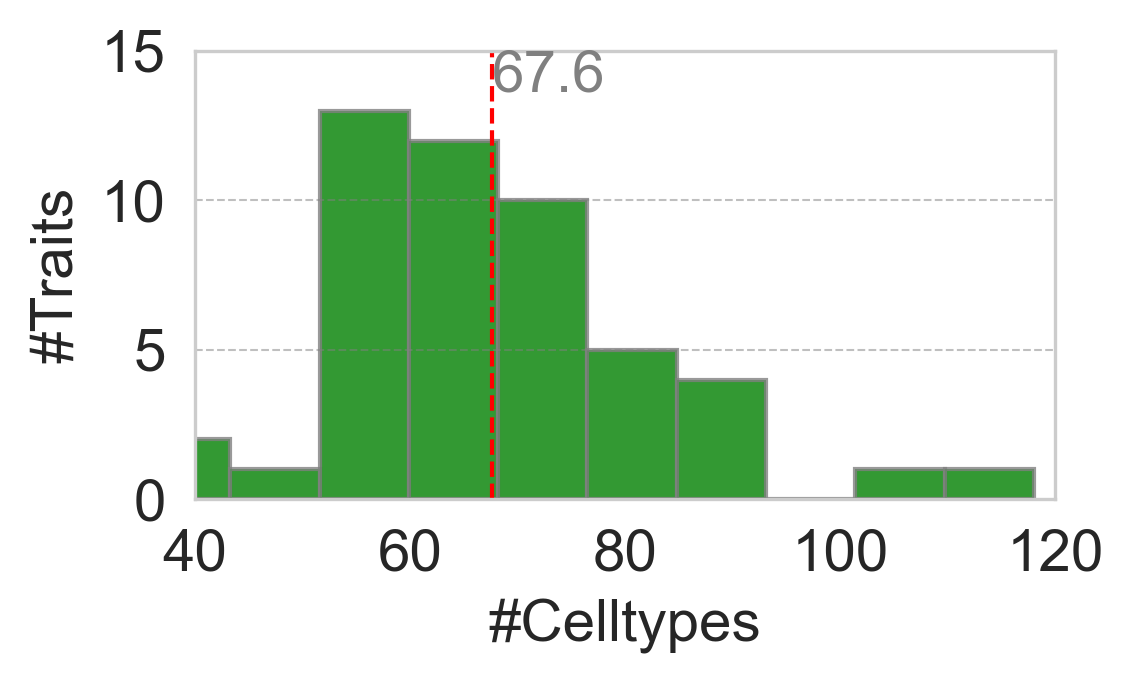

In [7]:
# 每个性状显著相关的细胞类型数量分布
alltraits_significant_core = pd.read_csv(r"E:\00_CeSOP\results\alltraits_significant_yesorno_celltypes_core.csv")
core_tissue_num = alltraits_significant_core.sum().values[1:-2]

plt.figure(figsize=(4,2.5),dpi = 300)
plt.axhline(y=5, color='grey', linestyle='--',alpha=0.5,linewidth=0.5)
plt.axhline(y=10, color='grey', linestyle='--',alpha=0.5,linewidth=0.5)
plt.hist(core_tissue_num, bins = 10, color='green',alpha = 0.8,edgecolor='grey')
# 计算数据的均值
mean_value = np.mean(core_tissue_num)
# 在x轴上绘制表示均值的竖线
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=1)
# 添加注释来标识均值
plt.text(mean_value, plt.ylim()[1], f'{mean_value:.1f}', color='grey')

plt.xlim(40,120)
plt.ylim(0,15)
plt.xlabel("#Celltypes")
plt.ylabel("#Traits")
plt.grid(False)
# 自动调整子图间的间距
plt.tight_layout()
plt.savefig(r"E:\00_CeSOP\results\figures\2.jpg",)
plt.show()
# 
# alltraits_significant_peri = pd.read_csv(r"E:\00_CeSOP\results\alltraits_significant_yesorno_celltypes_peri.csv")
# peri_tissue_num = alltraits_significant_peri.sum().values[1:-2]
# # 计算数据的均值
# mean_value = np.mean(peri_tissue_num)
# plt.figure(figsize=(4,2.5))
# plt.axhline(y=5, color='grey', linestyle='--',alpha=0.5,linewidth=0.5)
# plt.axhline(y=10, color='grey', linestyle='--',alpha=0.5,linewidth=0.5)
# plt.hist(peri_tissue_num, bins = 10, color='green',alpha = 0.3, edgecolor='grey')
# # 在x轴上绘制表示均值的竖线
# plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=1)
# # 添加注释来标识均值
# plt.text(mean_value, plt.ylim()[1]*0.9, f'{mean_value:.1f}', color='grey')
# plt.xlim(40,120)
# plt.ylim(0,15)
# plt.xlabel("#Celltypes")
# plt.ylabel("#Traits")
# plt.grid(False)
# plt.show()




In [8]:
alltraits_significant_core = pd.read_csv(r"E:\00_CeSOP\results\alltraits_significant_yesorno_tissues_core.csv")
alltraits_significant_core[alltraits_significant_core["Asthma Diagnosed"]==1]["tissue"]

0            Bladder
3                Eye
4                Fat
5              Heart
9               Lung
12            Muscle
13          Pancreas
15    Salivary_Gland
21           Trachea
22            Uterus
23       Vasculature
Name: tissue, dtype: object

In [151]:
'''计算均值和标准差'''
alltraits_significant_peri = pd.read_csv(r"E:\00_CeSOP\results\alltraits_significant_yesorno_tissues_peri.csv")
peri_tissue_num = alltraits_significant_peri.sum().values[1:-2]
# 计算数据的均值
mean_value = np.mean(peri_tissue_num)
std_value = np.std(peri_tissue_num)
print(mean_value,std_value)

9 1.7770734483252002


In [18]:
'''计算显著相关的细胞类型有多少是相关组织上的'''
alltraits_significant_core_t = pd.read_csv(r"E:\00_CeSOP\results\alltraits_significant_yesorno_tissues_core.csv")
alltraits_significant_core_ct = pd.read_csv(r"E:\00_CeSOP\results\alltraits_significant_yesorno_celltypes_core.csv")

# HbA1c = "Age of Menarche"
# HbA1c = "Height"
HbA1c = "HbA1c"
HbA1c_t = alltraits_significant_core_t[[HbA1c, "tissue"]]
HbA1c_t_1 = HbA1c_t[HbA1c_t[HbA1c] == 1]
HbA1c_t_1_tissues = list(HbA1c_t_1["tissue"])

HbA1c_ct = alltraits_significant_core_ct[[HbA1c,"tissue","celltype"]]
HbA1c_ct_1 = HbA1c_ct[HbA1c_ct[HbA1c]==1]
HbA1c_ct_1[HbA1c_ct_1["tissue"].isin(HbA1c_t_1_tissues)]

HbA1c           tissue                                celltype
1        1          Bladder                 bladder urothelial cell
4        1          Bladder                              fibroblast
8        1          Bladder                                 nk cell
13       1          Bladder                                  t cell
18       1            Blood  cd4-positive, alpha-beta memory t cell
19       1            Blood         cd4-positive, alpha-beta t cell
21       1            Blood         cd8-positive, alpha-beta t cell
23       1            Blood                             erythrocyte
93       1              Fat                              fibroblast
97       1              Fat                   mesenchymal stem cell
103      1              Fat                                  t cell
124      1  Large_Intestine                     immature enterocyte
131      1  Large_Intestine                       mature enterocyte

In [186]:
'''可视化几个特例性状的显著细胞类型所在的组织比例'''

# HbA1c = "Age of Menarche"
# HbA1c = "Height"
# HbA1c = "Tanning"
HbA1c = "Asthma Diagnosed"
# HbA1c = "HbA1c"
HbA1c_t = alltraits_significant_core_t[[HbA1c, "tissue"]]
HbA1c_t_1 = HbA1c_t[HbA1c_t[HbA1c] == 1]
HbA1c_t_1_tissues = list(HbA1c_t_1["tissue"])

HbA1c_ct = alltraits_significant_core_ct[[HbA1c,"tissue","celltype"]]
HbA1c_ct_1 = HbA1c_ct[HbA1c_ct[HbA1c]==1]
HbA1c_ct_1[HbA1c_ct_1["tissue"].isin(HbA1c_t_1_tissues)]

group_counts = HbA1c_ct_1['tissue'].value_counts()
# 指定需要特殊颜色的标签列表
special_labels = HbA1c_t_1_tissues
# 定义颜色映射
# colors = []
# for label in group_counts.index:
#     if label in special_labels:
#         colors.append('green')  # 特殊标签颜色
#     else:
#         colors.append('grey')  # 默认颜色
# 绘制比例饼状图
# fig, ax = plt.subplots(figsize=(4, 4))
# wedges, texts, autotexts = ax.pie(group_counts, labels=group_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
# # 设置百分比标签颜色和字体大小
# for autotext, label in zip(autotexts, group_counts.index):
#     autotext.set_fontsize(10)  # 设置百分比标签字体大小
import plotly.graph_objects as go
import random
labels = list(group_counts.index.values)
# 设置特殊标签的显示样式
special_labels = HbA1c_t_1_tissues

# 创建扇形图
fig = go.Figure(data=[go.Pie(labels=labels, values=group_counts, textinfo='label+value', textposition='outside')])

# 更新布局
fig.update_layout(title=HbA1c,
                    width=500,  # 宽度
                    height=500,  # 高度
                  showlegend=False  # 不显示图例
                        )

# 设置标签显示，包括特殊标签的字体颜色
fig.data[0].update(
    # text=labels, 
    # textinfo='label+value',
    textfont=dict(
        color=['black' if label not in special_labels else 'green' for label in labels]
    )
)

# 添加标题并设置标题位置
fig.update_layout(
    title={
        'text': HbA1c,
        'x': 0.3,  # 标题居中
        'y': 0.95,  # 标题位置
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

# plt.title(HbA1c)
fig.show()

In [256]:
'''计算显著相关的细胞类型有多少是相关组织上的'''
alltraits_significant_core_t = pd.read_csv(r"E:\00_CeSOP\results\alltraits_significant_yesorno_tissues_peri.csv")
alltraits_significant_core_ct = pd.read_csv(r"E:\00_CeSOP\results\alltraits_significant_yesorno_celltypes_peri.csv")

# HbA1c = "Age of Menarche"
# HbA1c = "Height"
HbA1c = "Psoriasis"
HbA1c_t = alltraits_significant_core_t[[HbA1c, "tissue"]]
HbA1c_t_1 = HbA1c_t[HbA1c_t[HbA1c] == 1]
HbA1c_t_1_tissues = list(HbA1c_t_1["tissue"])

HbA1c_ct = alltraits_significant_core_ct[[HbA1c,"tissue","celltype"]]
HbA1c_ct_1 = HbA1c_ct[HbA1c_ct[HbA1c]==1]
HbA1c_ct_1[HbA1c_ct_1["tissue"].isin(HbA1c_t_1_tissues)]

Psoriasis           tissue                                      celltype
92         1.0              Fat                              endothelial cell
95         1.0              Fat                                    macrophage
100        1.0              Fat                                       nk cell
120        1.0  Large_Intestine   enterocyte of epithelium of large intestine
122        1.0  Large_Intestine                                   goblet cell
129        1.0  Large_Intestine                   large intestine goblet cell
131        1.0  Large_Intestine                             mature enterocyte
134        1.0  Large_Intestine  paneth cell of epithelium of large intestine
138        1.0            Liver          endothelial cell of hepatic sinusoid
141        1.0            Liver                                    hepatocyte
147        1.0            Liver                                       nk cell
193        1.0       Lymph_Node                cd4-positive alpha-beta t cell
194        1.0       Lymph_Node        cd4-positive, alpha-beta memory t cell
201        1.0       Lymph_Node                          innate lymphoid cell
203        1.0       Lymph_Node                                    macrophage
211        1.0       Lymph_Node                                       nk cell
215        1.0       Lymph_Node                             regulatory t cell
217        1.0       Lymph_Node                                        t cell
218        1.0       Lymph_Node                              type i nk t cell
233        1.0           Muscle                    capillary endothelial cell
241        1.0           Muscle                                    macrophage
245        1.0           Muscle                              mesothelial cell

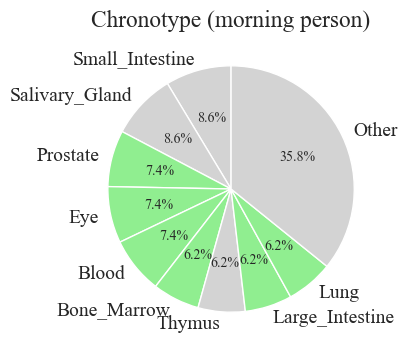

In [267]:

# HbA1c = "Psoriasis"
# HbA1c = "Red Blood Cell Dist. Width"
# HbA1c = "Endocrine Diabetes"
HbA1c = "Chronotype (morning person)"

HbA1c_t = alltraits_significant_core_t[[HbA1c, "tissue"]]
HbA1c_t_1 = HbA1c_t[HbA1c_t[HbA1c] == 1]
HbA1c_t_1_tissues = list(HbA1c_t_1["tissue"])

HbA1c_ct = alltraits_significant_core_ct[[HbA1c,"tissue","celltype"]]
HbA1c_ct_1 = HbA1c_ct[HbA1c_ct[HbA1c]==1]
HbA1c_ct_1[HbA1c_ct_1["tissue"].isin(HbA1c_t_1_tissues)]

group_counts = HbA1c_ct_1['tissue'].value_counts()
total_count = group_counts.sum()
# 计算各类别的比例并将比例小于5%的类别合并为 'Other'
threshold = 0.05
group_percent = group_counts / total_count
small_categories = group_percent[group_percent < threshold].index
# 创建新的分组计数，合并小于5%的类别为 'Other'
group_counts['Other'] = group_counts[small_categories].sum()
group_counts = group_counts.drop(small_categories)

# 指定需要特殊颜色的标签列表
special_labels = HbA1c_t_1_tissues
# 定义颜色映射
colors = []
for label in group_counts.index:
    if label in special_labels:
        colors.append('lightgreen')  # 特殊标签颜色
    else:
        colors.append('lightgrey')  # 默认颜色
# 绘制比例饼状图
fig, ax = plt.subplots(figsize=(4, 4))
wedges, texts, autotexts = ax.pie(group_counts, labels=group_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
# 设置百分比标签颜色和字体大小
for autotext, label in zip(autotexts, group_counts.index):
    autotext.set_fontsize(10)  # 设置百分比标签字体大小
plt.title(HbA1c)
plt.show()

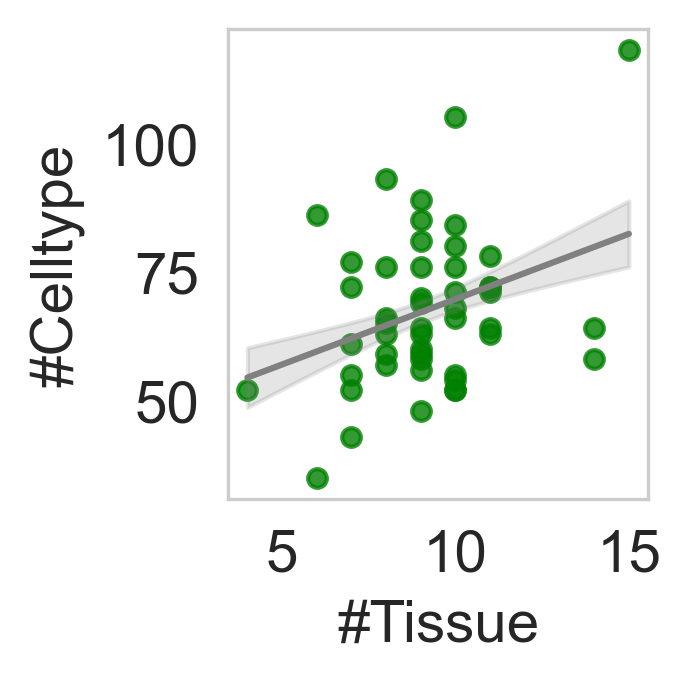

In [8]:
''' 细胞类型特异性强的性状其组织特异性不一定强，散点图'''
# 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

alltraits_significant_core_t = pd.read_csv(r"E:\00_CeSOP\results\alltraits_significant_yesorno_tissues_core.csv")
core_tissue_num = np.array(alltraits_significant_core_t.sum().values[1:], dtype=float)
alltraits_significant_core_ct = pd.read_csv(r"E:\00_CeSOP\results\alltraits_significant_yesorno_celltypes_core.csv")
core_celltype_num = np.array(alltraits_significant_core_ct.sum().values[1:-2], dtype=float)

plt.figure(figsize=(2.5, 2.5),dpi = 300)
# 创建散点图
plt.scatter(core_tissue_num, core_celltype_num,s = 20,alpha = 0.8,c= 'green')
# 计算线性回归的拟合参数
coefficients = np.polyfit(core_tissue_num, core_celltype_num, 1)
poly = np.poly1d(coefficients)
# 生成拟合线的 x 值
x_fit = np.linspace(core_tissue_num.min(), core_tissue_num.max(), 100)
y_fit = poly(x_fit)
# 计算残差
residuals = core_celltype_num - poly(core_tissue_num)
std_err = np.sqrt(np.sum(residuals**2) / (len(core_celltype_num) - 2))
# 计算拟合线的标准误差
y_err = std_err * np.sqrt(1/len(core_celltype_num) + (x_fit - core_tissue_num.mean())**2 / np.sum((core_tissue_num - core_tissue_num.mean())**2))
# 绘制拟合线
plt.plot(x_fit, y_fit, color='grey', label='Fitted Line')

# 绘制阴影区域
plt.fill_between(x_fit, y_fit - y_err, y_fit + y_err, color='grey', alpha=0.2, label='Confidence Interval')
# 添加标题和标签
# plt.title('Scatter Plot Example')
plt.xlabel('#Tissue')
plt.ylabel('#Celltype')
plt.grid(False)
# 自动调整子图间的间距
plt.tight_layout()
plt.savefig(r"E:\00_CeSOP\results\figures\3.jpg")
# 显示图表
plt.show()

In [4]:
poly

poly1d([ 2.53683766, 44.31475617])

### 组织、细胞类型在多少个性状上显著相关

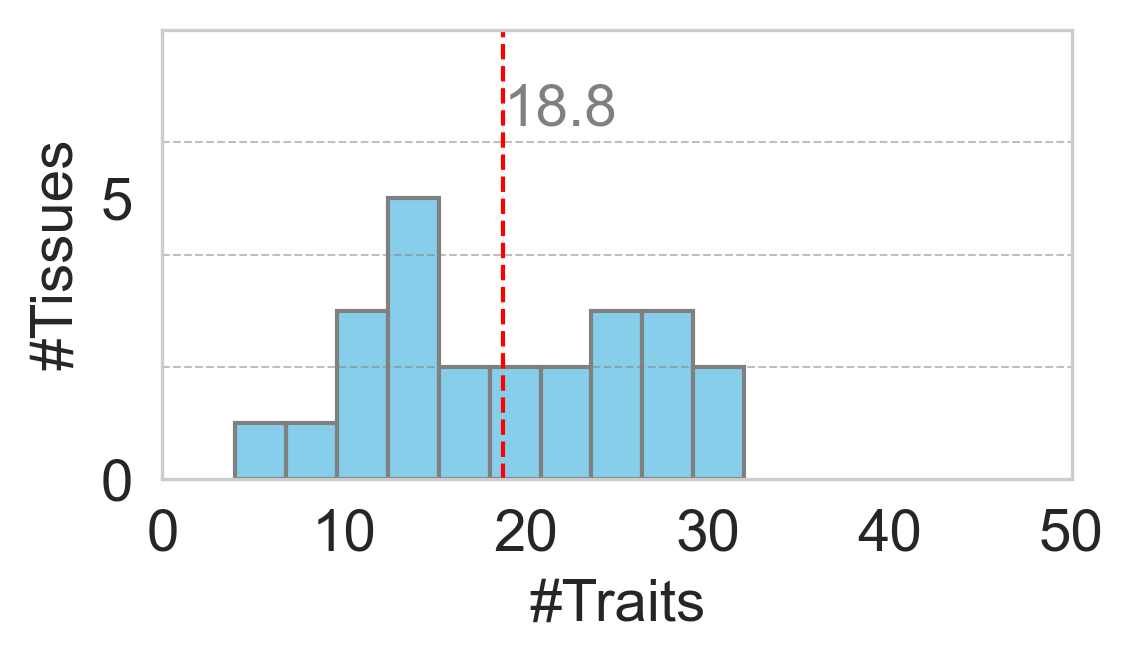

In [9]:
alltraits_significant_core = pd.read_csv(r"E:\00_CeSOP\results\alltraits_significant_yesorno_tissues_core.csv")
core_tissue_num = alltraits_significant_core.iloc[:,1:].T.sum()
core_tissue_num = pd.DataFrame(core_tissue_num)
core_tissue_num.columns = ["number"]
core_tissue_num.index = alltraits_significant_core["tissue"]
plt.figure(figsize=(4,2.5),dpi = 300)
plt.axhline(y=2, color='grey', linestyle='--',alpha=0.5,linewidth=0.5)
plt.axhline(y=4, color='grey', linestyle='--',alpha=0.5,linewidth=0.5)
plt.axhline(y=6, color='grey', linestyle='--',alpha=0.5,linewidth=0.5)
plt.hist(core_tissue_num["number"],bins = 10,color='skyblue', edgecolor='grey')
# 计算数据的均值
mean_value = np.mean(core_tissue_num["number"])
# 在x轴上绘制表示均值的竖线
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=1)
# 添加注释来标识均值
plt.text(mean_value, plt.ylim()[1], f'{mean_value:.1f}', color='grey')
plt.xlim(0,50)
plt.ylim(0,8)
plt.grid(False)
plt.ylabel("#Tissues")
plt.xlabel("#Traits")
# 自动调整子图间的间距
plt.tight_layout()
plt.savefig(r"E:\00_CeSOP\results\figures\4.jpg")
plt.show()
# 
# alltraits_significant_peri = pd.read_csv(r"E:\00_CeSOP\results\alltraits_significant_yesorno_tissues_peri.csv")
# peri_tissue_num = alltraits_significant_peri.iloc[:,1:].T.sum()
# peri_tissue_num = pd.DataFrame(peri_tissue_num)
# peri_tissue_num.columns = ["number"]
# peri_tissue_num.index = alltraits_significant_peri["tissue"]
# plt.figure(figsize=(4,2.5))
# plt.axhline(y=2, color='grey', linestyle='--',alpha=0.5,linewidth=0.5)
# plt.axhline(y=4, color='grey', linestyle='--',alpha=0.5,linewidth=0.5)
# plt.axhline(y=6, color='grey', linestyle='--',alpha=0.5,linewidth=0.5)
# plt.hist(peri_tissue_num["number"],  bins = 10,color='skyblue',alpha = 0.5, edgecolor='grey')
# # 计算数据的均值
# mean_value = np.mean(peri_tissue_num["number"])
# # 在x轴上绘制表示均值的竖线
# plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=1)
# # 添加注释来标识均值
# plt.text(mean_value, plt.ylim()[1], f'{mean_value:.1f}', color='grey')
# plt.xlim(0,50)
# plt.ylim(0,8)
# plt.grid(False)
# plt.ylabel("#Tissues")
# plt.xlabel("#Traits")
# plt.show()

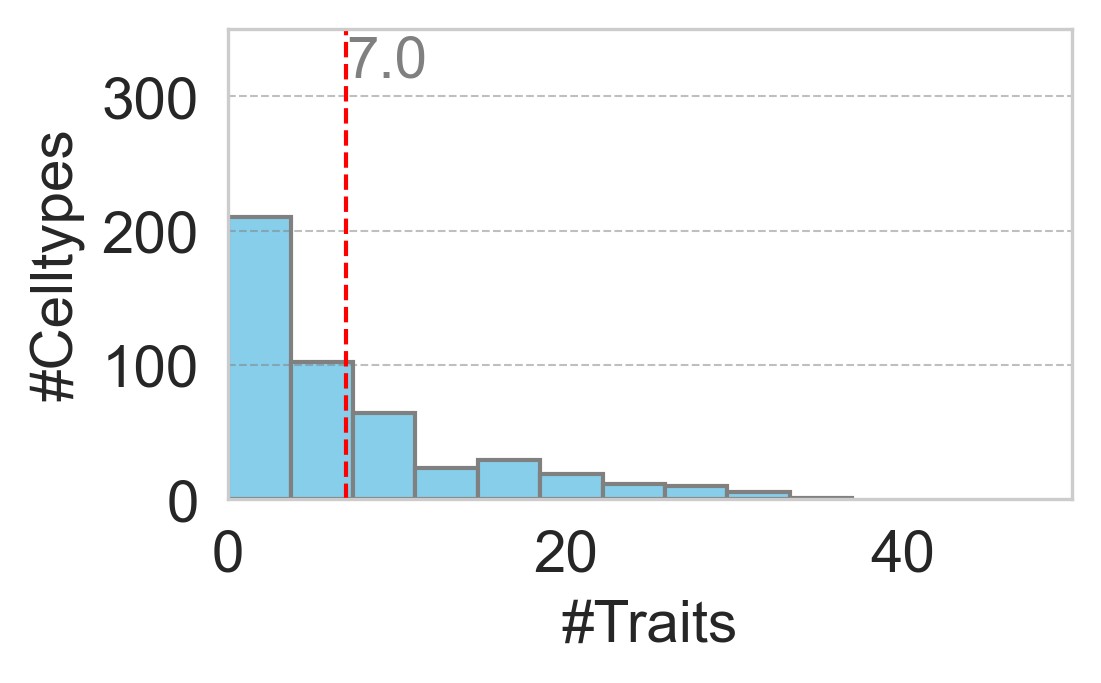

In [10]:
alltraits_significant_core = pd.read_csv(r"E:\00_CeSOP\results\alltraits_significant_yesorno_celltypes_core.csv")
core_tissue_num = alltraits_significant_core.iloc[:,1:-2].T.sum()
core_tissue_num = pd.DataFrame(core_tissue_num)
core_tissue_num.columns = ["number"]
core_tissue_num["tissue"] = alltraits_significant_core.iloc[:,-2]
core_tissue_num["celltype"] = alltraits_significant_core.iloc[:,-1]
plt.figure(figsize=(4,2.5),dpi = 300)
plt.axhline(y=100, color='grey', linestyle='--',alpha=0.5,linewidth=0.5)
plt.axhline(y=200, color='grey', linestyle='--',alpha=0.5,linewidth=0.5)
plt.axhline(y=300, color='grey', linestyle='--',alpha=0.5,linewidth=0.5)
plt.hist(core_tissue_num["number"],color='skyblue', edgecolor='grey')
# 计算数据的均值
mean_value = np.mean(core_tissue_num["number"])
# 在x轴上绘制表示均值的竖线
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=1)
# 添加注释来标识均值
plt.text(mean_value, plt.ylim()[1], f'{mean_value:.1f}', color='grey')
plt.xlim(0,50)
plt.ylim(0,350)
plt.grid(False)
plt.ylabel("#Celltypes")
plt.xlabel("#Traits")
# 自动调整子图间的间距
plt.tight_layout()
plt.savefig(r"E:\00_CeSOP\results\figures\5.jpg",)
plt.show()
# 
# alltraits_significant_peri = pd.read_csv(r"E:\00_CeSOP\results\alltraits_significant_yesorno_celltypes_peri.csv")
# peri_tissue_num = alltraits_significant_peri.iloc[:,1:-2].T.sum()
# peri_tissue_num = pd.DataFrame(peri_tissue_num)
# peri_tissue_num.columns = ["number"]
# peri_tissue_num["tissue"] = alltraits_significant_peri.iloc[:,-2]
# peri_tissue_num["celltype"] = alltraits_significant_peri.iloc[:,-1]
# plt.figure(figsize=(4,2.5))
# # plt.axhline(y=5, color='grey', linestyle='--',alpha=0.5,linewidth=0.5)
# # plt.axhline(y=10, color='grey', linestyle='--',alpha=0.5,linewidth=0.5)
# plt.hist(peri_tissue_num["number"],  color='skyblue',alpha = 0.5, edgecolor='grey')
# plt.axhline(y=100, color='grey', linestyle='--',alpha=0.5,linewidth=0.5)
# plt.axhline(y=200, color='grey', linestyle='--',alpha=0.5,linewidth=0.5)
# plt.axhline(y=300, color='grey', linestyle='--',alpha=0.5,linewidth=0.5)
# # 计算数据的均值
# mean_value = np.mean(peri_tissue_num["number"])
# # 在x轴上绘制表示均值的竖线
# plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=1)
# # 添加注释来标识均值
# plt.text(mean_value, plt.ylim()[1], f'{mean_value:.1f}', color='grey')
# plt.xlim(0,50)
# plt.ylim(0,350)
# plt.grid(False)
# plt.ylabel("#Celltypes")
# plt.xlabel("#Traits")
# plt.show()

In [245]:
'''统计每个组织中的细胞类型在多少个性状中显著相关'''
alltraits_significant_core = pd.read_csv(r"E:\00_CeSOP\results\alltraits_significant_yesorno_celltypes_peri.csv")
core_tissue_num = alltraits_significant_core.iloc[:,1:-2].T.sum()
core_tissue_num = pd.DataFrame(core_tissue_num)
core_tissue_num.columns = ["number"]
core_tissue_num["tissue"] = alltraits_significant_core.iloc[:,-2]
core_tissue_num["celltype"] = alltraits_significant_core.iloc[:,-1]
core_tissue_num[core_tissue_num["number"] < 10]

number       tissue                              celltype
0       0.0      Bladder                                b cell
2       1.0      Bladder            capillary endothelial cell
3       1.0      Bladder  endothelial cell of lymphatic vessel
4       8.0      Bladder                            fibroblast
5       8.0      Bladder                            macrophage
..      ...          ...                                   ...
466     2.0  Vasculature            lymphatic endothelial cell
468     0.0  Vasculature                             mast cell
469     1.0  Vasculature                               nk cell
471     2.0  Vasculature                           plasma cell
473     0.0  Vasculature                                t cell

[359 rows x 3 columns]

In [14]:
names = pd.read_excel(r"E:\00_CeSOP\results\tissues-names.xlsx")


tissue  name
0           Bladder    膀胱
1             Blood    血液
2       Bone_Marrow    骨髓
3               Eye    眼睛
4               Fat    脂肪
5             Heart     心
6            Kidney    肾脏
7   Large_Intestine    大肠
8             Liver    肝脏
9              Lung     肺
10       Lymph_Node   淋巴结
11          Mammary    乳房
12           Muscle    肌肉
13         Pancreas    胰腺
14         Prostate   前列腺
15   Salivary_Gland   唾液腺
16             Skin    皮肤
17  Small_Intestine    小肠
18           Spleen     脾
19           Thymus    胸腺
20           Tongue    舌头
21          Trachea    气管
22           Uterus    子宫
23      Vasculature  脉管系统

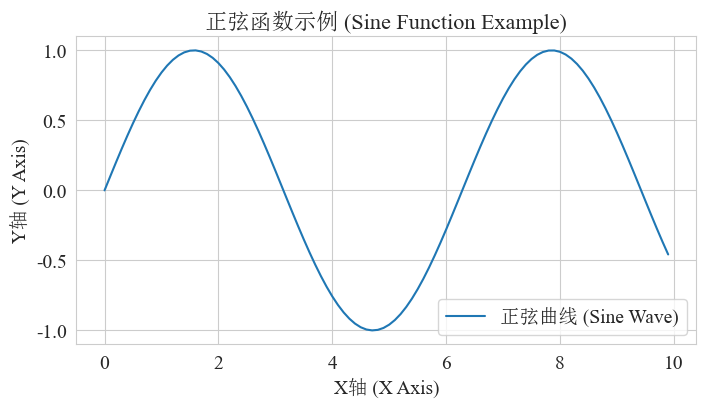

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# 设置全局字体
plt.rcParams['font.family']=' Times New Roman, SimSun'# 设置字体族，中文为SimSun，英文为Times New Roman
plt.rcParams['mathtext.fontset'] = 'stix' # 设置数学公式字体为stix

# 示例数据
x = np.arange(0, 10, 0.1)
y = np.sin(x)

# 创建图表
plt.figure(figsize=(8, 4))
plt.plot(x, y, label="正弦曲线 (Sine Wave)")

# 添加标题和标签
plt.title("正弦函数示例 (Sine Function Example)", fontsize=16)
plt.xlabel("X轴 (X Axis)", fontsize=14)
plt.ylabel("Y轴 (Y Axis)", fontsize=14)

# 显示图例
plt.legend()

# 显示图表
plt.show()

Skin
Muscle
Tongue
Small_Intestine
Large_Intestine
Lymph_Node
Prostate
Kidney
Salivary_Gland
Blood
Mammary
Thymus
Trachea
Bladder
Heart
Pancreas
Spleen
Eye
Fat
Bone_Marrow
Uterus
Vasculature
Liver
Lung


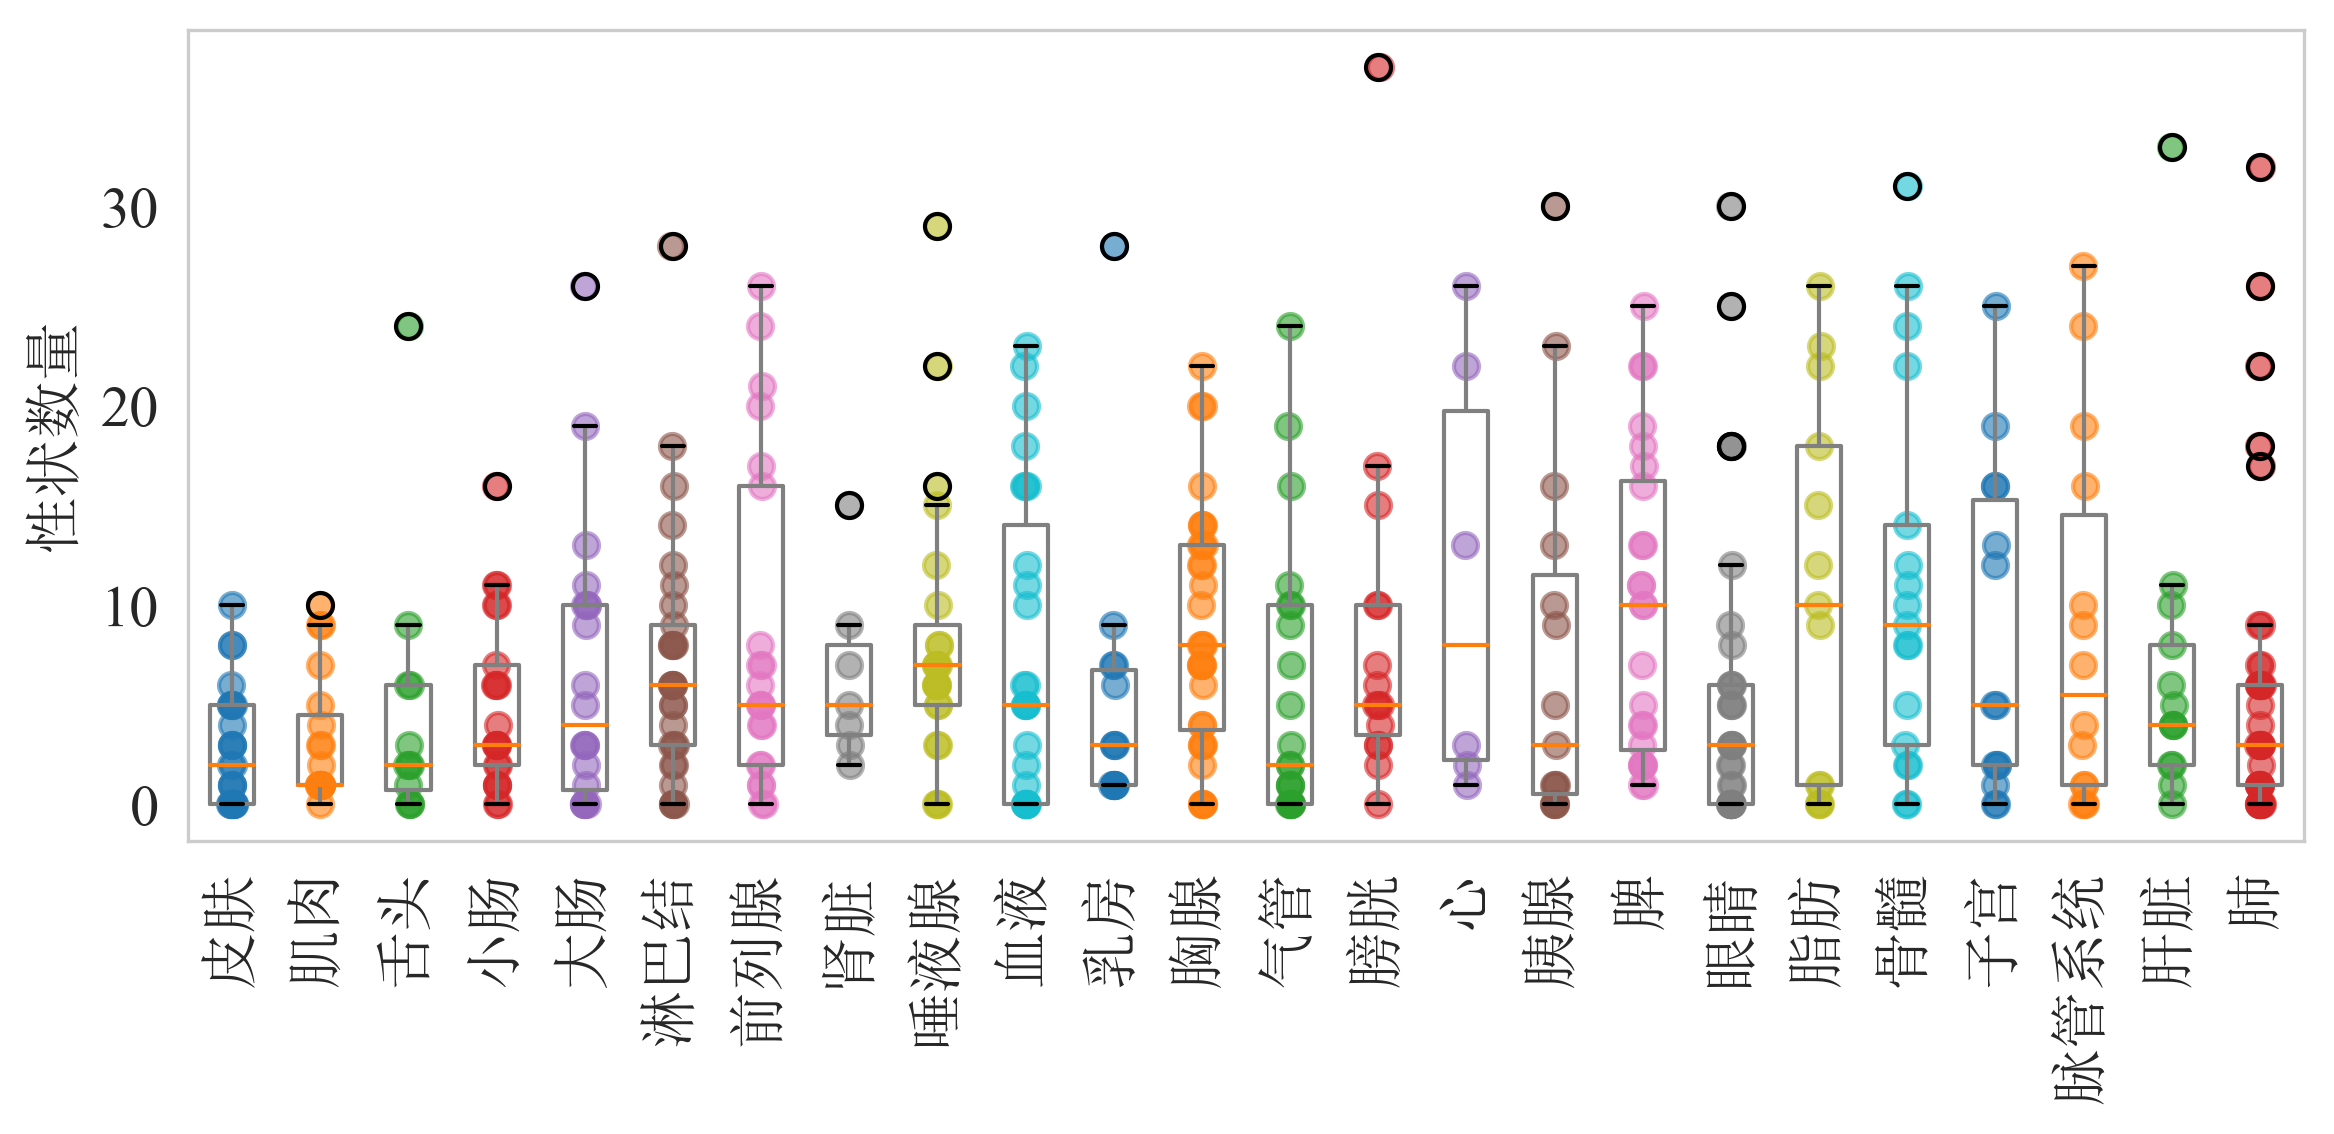

In [28]:
# 设置全局字体
plt.rcParams['font.family']=' Times New Roman, SimSun'# 设置字体族，中文为SimSun，英文为Times New Roman
plt.rcParams['mathtext.fontset'] = 'stix' # 设置数学公式字体为stix

'''倾向于与多个性状相关的组织其中的细胞类型也倾向于与多个性状相关'''
alltraits_significant_core = pd.read_csv(r"E:\00_CeSOP\results\alltraits_significant_yesorno_celltypes_core.csv")
core_tissue_num = alltraits_significant_core.iloc[:,1:-2].T.sum()
core_tissue_num = pd.DataFrame(core_tissue_num)
core_tissue_num.columns = ["number"]
core_tissue_num["tissue"] = alltraits_significant_core.iloc[:,-2]
core_tissue_num["celltype"] = alltraits_significant_core.iloc[:,-1]
# print(np.mean(core_tissue_num) ,np.std(core_tissue_num))

alltraits_significant_core_t = pd.read_csv(r"E:\00_CeSOP\results\alltraits_significant_yesorno_tissues_core.csv")
core_tissue_num_t = alltraits_significant_core_t.iloc[:,1:].T.sum()
core_tissue_num_t = pd.DataFrame(core_tissue_num_t)
core_tissue_num_t.columns = ["number"]
core_tissue_num_t.index = alltraits_significant_core_t["tissue"]
core_tissue_num_t_sorted = core_tissue_num_t.sort_values("number")
tissues = list(core_tissue_num_t_sorted.index)


## 使用组织的中文名称
names = pd.read_excel(r"E:\00_CeSOP\results\tissues-names.xlsx")
# 将列 'a' 转换为分类类型，并按照列表 l 的顺序排序
names['tissue'] = pd.Categorical(names['tissue'], categories=tissues, ordered=True)
# 按照列 'a' 进行排序
names = names.sort_values('tissue')
# 重置索引（可选）
names = names.reset_index(drop=True)

all_number = []
for t in tissues: 
    print(t)
    tissue_ct = core_tissue_num[core_tissue_num['tissue']==t]["number"]
    all_number.append(list(tissue_ct))

# 设置图形大小
plt.figure(figsize=(8, 4),dpi = 300)
# 创建箱线图
box = plt.boxplot(all_number,boxprops=dict(color='grey'), whiskerprops=dict(color='grey'))
# 绘制散点图
for i, d in enumerate(all_number, 1):
    y = d
    x = np.random.normal(i, 0.01, size=len(y))  # 在x轴位置上添加一些随机抖动
    plt.scatter(x, y, alpha=0.6)
    
# 添加标题和标签
# plt.title('Scatter Plot of Multiple Lists')
# plt.xticks(range(1, len(all_number) + 1), tissues, rotation=90)
plt.xticks(range(1, len(all_number) + 1), names["name"], rotation=90)

plt.grid(False)
# plt.ylabel("#Traits")
plt.ylabel("性状数量")
# 自动调整子图间的间距
plt.tight_layout()
plt.savefig(r"E:\00_CeSOP\results\figures\6.jpg",)
plt.show()


### 利用ldsc的结果验证“根据组织特异性对性状进行聚类”的结果

Silhouette Score: 0.20603266638480852
Calinski-Harabasz Score: 6.617984237746261


([<matplotlib.axis.XTick at 0x16073211190>,
 [Text(1, 0, 'Intra'), Text(2, 0, 'Inter')])

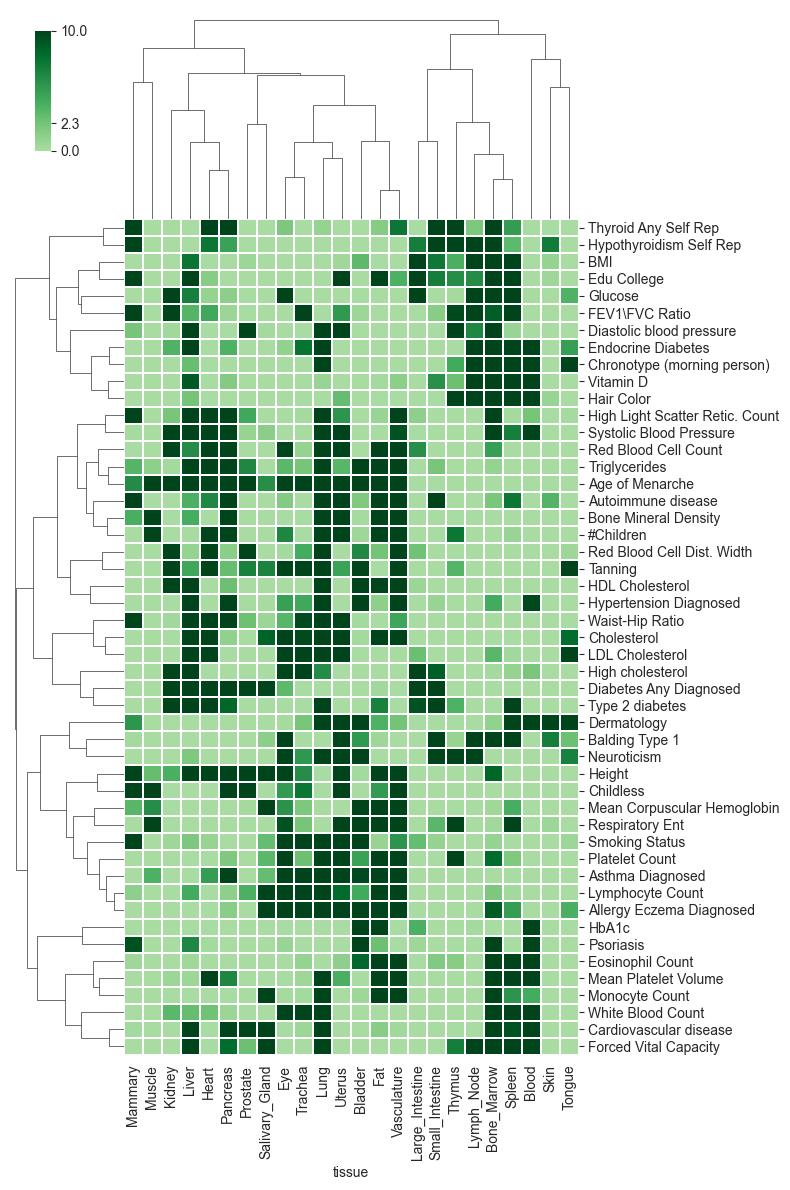

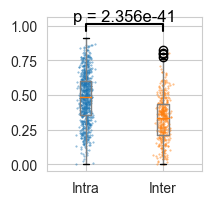

In [3]:
'''根据组织特异性对性状进行聚类，并输出聚类结果'''
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

epsilon = 1e-10
core = "core"
traits_name = pd.read_excel(r"E:\00_CeSOP\data\49_traits.xlsx")
alltraits_significant = pd.DataFrame()
for trait in range(1, 50):
    trait_name = traits_name[traits_name["Number"] == trait]["Trait name"].values[0]
    # trait_name = traits_name[traits_name["Number"] == trait]["Trait 名字"].values[0]
    df = pd.read_csv(
        r"E:\00_CeSOP\results\trait-cells-in-tissues-and-celltypes\tissues\%s\top10_%s_lcczscore.csv" % (trait, core))
    df = df.sort_values("tissue")
    df["log fisher's pvalue"] = -np.log10(df["fisher's pvalue"] + + epsilon)
    alltraits_significant[trait_name] = df["log fisher's pvalue"]
alltraits_significant.index = df["tissue"]

'''层次聚类'''
alltraits_significant_T = alltraits_significant.T
x = -np.log10(0.005 + epsilon)
cg = sns.clustermap(alltraits_significant_T, cmap='Greens', figsize=(8, 12), linewidths=0.01,
                    xticklabels=True, yticklabels=True,
                    method='complete', metric='cosine',
                    cbar_pos=(0.05, 0.87, 0.02, 0.1),
                    cbar_kws={'ticks': [0, x, 10]},
                    center=x)  #行是组织，列是性状
# plt.show()

'''计算每两列(性状）之间的余弦相似度'''
cosine_similarities = pd.DataFrame(index=alltraits_significant.columns, columns=alltraits_significant.columns)
for col1 in alltraits_significant.columns:
    for col2 in alltraits_significant.columns:
        if col1 != col2:
            cosine_similarities.loc[col1, col2] = 1 - cosine(alltraits_significant[col1], alltraits_significant[col2])
        else:
            cosine_similarities.loc[col1, col2] = 1  # 自身与自身的相似度为1
# 转换为数值类型
cosine_similarities = cosine_similarities.astype(float)
# 转换为一维数组，提取两两之间的相关系数
correlation_list = []
rows, cols = cosine_similarities.shape
for i in range(rows):
    for j in range(i + 1, cols):
        correlation_list.append(
            (cosine_similarities.index[i], cosine_similarities.columns[j], cosine_similarities.iat[i, j]))
# 转换为DataFrame并显示
correlation_df = pd.DataFrame(correlation_list, columns=['Node1', 'Node2', 'value'])
# correlation_df.to_csv(r"E:\00_CeSOP\results\temp\cytoscape\traits_cosine_similarity_for_tissues\edges.csv", index=None)

'''提取聚类结果'''
# 计算余弦距离矩阵
cosine_distance = pdist(alltraits_significant_T, metric='cosine')  # Transpose to calculate column distances
# 生成层次聚类
linkage_matrix = sch.linkage(cosine_distance, method='complete')
# 划分簇，设置簇数为2
array = alltraits_significant_T.iloc[:, 0:-1].to_numpy()
cluster_assignments = sch.fcluster(linkage_matrix, t=2, criterion='maxclust')
# 添加簇分配结果到 DataFrame
alltraits_significant_T['Cluster'] = cluster_assignments

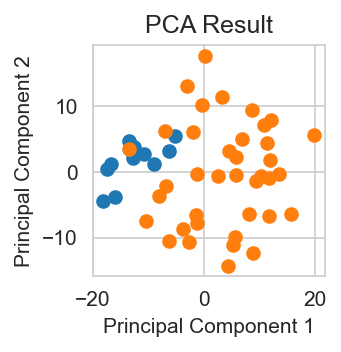

'思路二：簇内和簇间的ldsc 遗传相关性有显著差异'

In [33]:
'''如何验证组织特异性将性状聚为两簇'''
'''思路一：将性状的组织特征向量降到二维，这两簇的可视化有显著差异'''
from sklearn.decomposition import PCA
# 应用PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(alltraits_significant_T.iloc[:, :-1])
y = alltraits_significant_T.iloc[:, -1]  # 类别标签

plt.figure(figsize=(2, 2),dpi = 150)
# 绘制降维后的数据
for label in np.unique(y):
    plt.scatter(X_pca[y == label, 0], X_pca[y == label, 1], label=f'Group {label}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Result')
plt.show()


([<matplotlib.axis.XTick at 0x1607ca6c940>,
 [Text(1, 0, 'Intra'), Text(2, 0, 'Inter')])

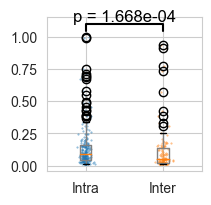

In [61]:
from scipy.stats import mannwhitneyu
'''思路二：簇内和簇间的ldsc 遗传相关性有显著差异'''
ldsc_traits = pd.read_csv(r"E:\00_CeSOP\results\ldsc_rg\ldsc\edges.csv")[["Node1","Node2","value"]]

intra_corr = []
inter_corr = []
for i in range(1, 3):
    group1 = list(alltraits_significant_T[alltraits_significant_T["Cluster"] == i].index)
    filtered_df = ldsc_traits[ldsc_traits['Node1'].isin(group1) & ldsc_traits['Node2'].isin(group1)]
    intra_corr.extend(list(filtered_df[filtered_df['value']>0.01]['value']))  #簇内

    filtered_df1 = ldsc_traits[ldsc_traits['Node1'].isin(group1) & ~ldsc_traits['Node2'].isin(group1)]
    inter_corr.extend(list(filtered_df1[filtered_df1['value']>0.01]['value']))  # 簇间

corr_list = [intra_corr, inter_corr]
# 散点箱线图
# 设置图形大小
plt.figure(figsize=(2, 2))
# 创建箱线图
box = plt.boxplot(corr_list, boxprops=dict(color='grey'), whiskerprops=dict(color='grey'))
# 绘制散点图
for i, d in enumerate(corr_list, 1):
    y = d
    x = np.random.normal(i, 0.04, size=len(y))  # 在x轴位置上添加一些随机抖动
    plt.scatter(x, y, alpha=0.6, s=0.2)

from scipy.stats import ttest_ind
# 计算 p 值
stat, p_value = mannwhitneyu(intra_corr, inter_corr, alternative='two-sided')
# t_stat, p_value = ttest_ind(intra_corr, inter_corr)
# 在箱体之间添加标示线和 p 值
x1, x2 = 1, 2
y, h, col = max(max(intra_corr), max(inter_corr)) + 0.05, 0.05, 'k'
plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
plt.text((x1 + x2) * .5, y + h, f"p = {p_value:.3e}", ha='center', va='bottom', color=col, fontsize=12)

# 设置自定义横轴坐标值和标签
custom_ticks = [1, 2]  # 自定义的横轴坐标值
custom_labels = ["Intra", "Inter"]  # 对应的标签
plt.xticks(custom_ticks, custom_labels)
# plt.grid(False)
# plt.title("rg of 2Groups")

### 对细胞类型聚类结果的分析

No NaN or inf values in the data.


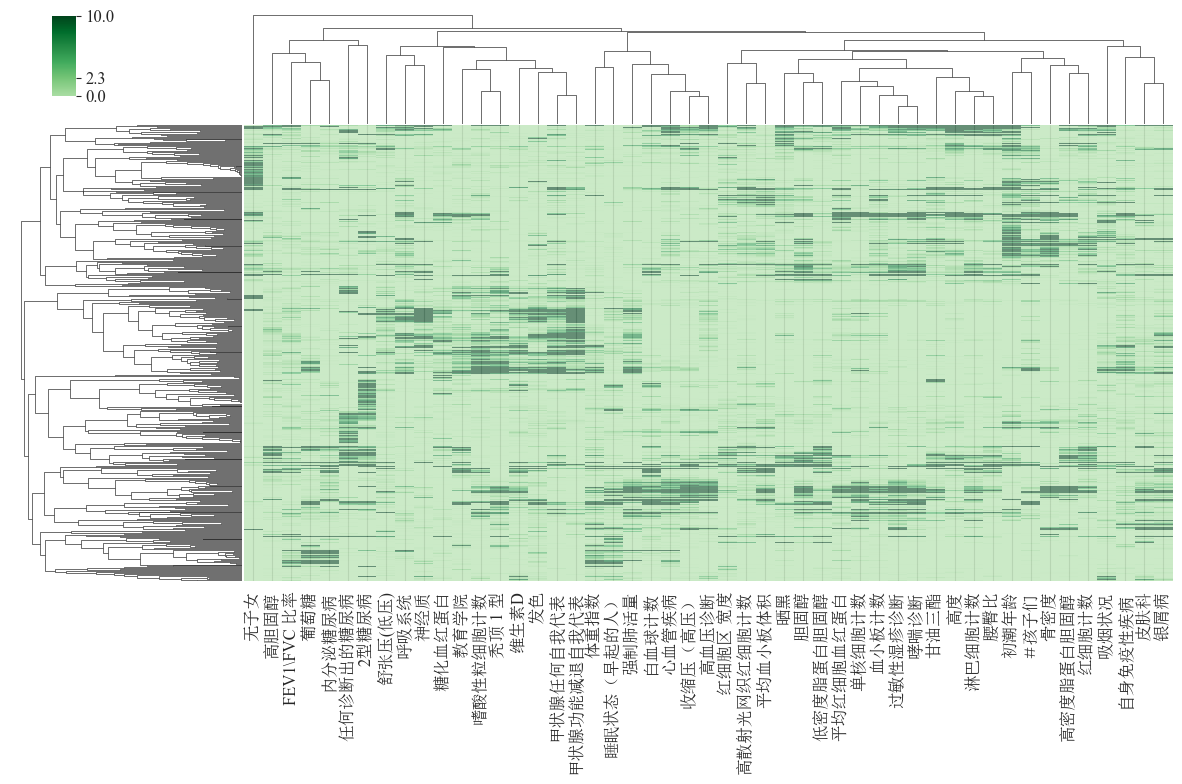

In [106]:
epsilon = 1e-10
core = "core"
# core = "peri"
traits_name = pd.read_excel(r"E:\00_CeSOP\data\49_traits.xlsx")
alltraits_significant = pd.DataFrame()
for trait in range(1,50):
    # trait_name = traits_name[traits_name["Number"] == trait]["Trait name"].values[0]
    trait_name = traits_name[traits_name["Number"] == trait]["Trait 名字"].values[0]
    df = pd.read_csv(r"E:\00_CeSOP\results\trait-cells-in-tissues-and-celltypes\celltypes\%s\top10_%s_lcczscore.csv"%(trait,core))
    df = df.sort_values(["tissue","celltype"])  
    df["log fisher's pvalue"] = -np.log10(df["fisher's pvalue"] + + epsilon)
    alltraits_significant[trait_name] = df["log fisher's pvalue"]
alltraits_significant.index = df["tissue"] + "---" + df["celltype"]
# 处理NaN和inf值
alltraits_significant = alltraits_significant.replace([np.inf, -np.inf], np.nan).dropna()
# 检查是否有NaN或inf值
if alltraits_significant.isnull().values.any():
    print("Data contains NaN or inf values.")
else:
    print("No NaN or inf values in the data.")

x = -np.log10(0.005 + epsilon)
cg = sns.clustermap(alltraits_significant, cmap='Greens', 
                    figsize=(12, 8),  linewidths = 0.002,
                    xticklabels=True ,  yticklabels=False,
                    method='weighted', metric='correlation',
                   # method='complete', metric='cosine',
                   cbar_pos=(0.05, 0.87, 0.02, 0.1),
                   cbar_kws={'ticks':[0,x,10]},
                   center=x)  #行是组织，列是性状
# 调整透明度
cg.ax_heatmap.collections[0].set_alpha(0.6)  # 设置透明度为 0.5
plt.show()

No NaN or inf values in the data.


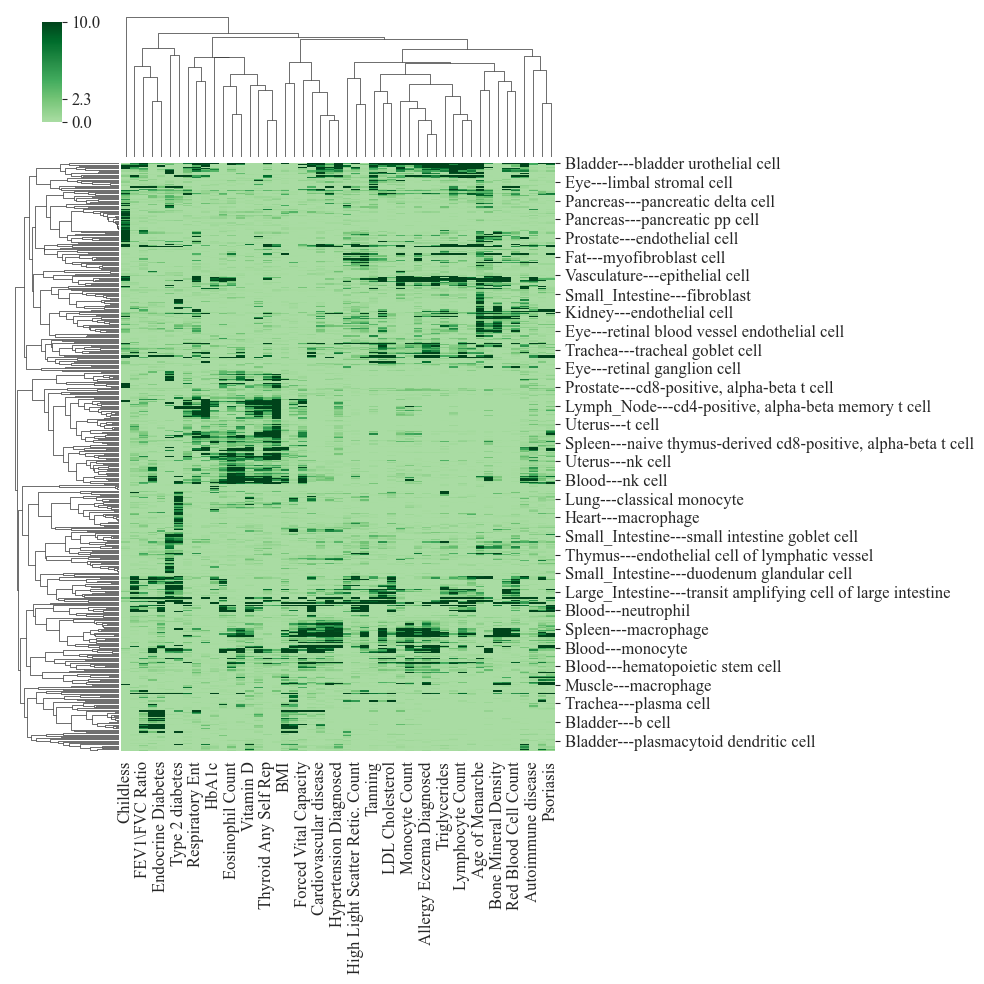

In [110]:
'''根据细胞类型特异性对细胞类型进行聚类，并输出聚类结果'''
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

plt.rcParams['font.family']=' Times New Roman, SimSun'# 设置字体族，中文为SimSun，英文为Times New Roman
plt.rcParams['mathtext.fontset'] = 'stix' # 设置数学公式字体为stix
# 设置全局字体大小
plt.rcParams['font.size'] = 12  # 设置全局字体大小

epsilon = 1e-10
core = "core"
traits_name = pd.read_excel(r"E:\00_CeSOP\data\49_traits.xlsx")
alltraits_significant = pd.DataFrame()
for trait in range(1,50):
    trait_name = traits_name[traits_name["Number"] == trait]["Trait name"].values[0]
    # trait_name = traits_name[traits_name["Number"] == trait]["Trait 名字"].values[0]
    df = pd.read_csv(r"E:\00_CeSOP\results\trait-cells-in-tissues-and-celltypes\celltypes\%s\top10_%s_lcczscore.csv"%(trait,core))
    df = df.sort_values(["tissue","celltype"])  
    df["log fisher's pvalue"] = -np.log10(df["fisher's pvalue"] + + epsilon)
    alltraits_significant[trait_name] = df["log fisher's pvalue"]
alltraits_significant.index = df["tissue"] + "---" + df["celltype"]
# 处理NaN和inf值
alltraits_significant = alltraits_significant.replace([np.inf, -np.inf], np.nan).dropna()
# 检查是否有NaN或inf值
if alltraits_significant.isnull().values.any():
    print("Data contains NaN or inf values.")
else:
    print("No NaN or inf values in the data.")

'''层次聚类'''
alltraits_significant_T = alltraits_significant.T
x = -np.log10(0.005 + epsilon)
cg = sns.clustermap(alltraits_significant, cmap='Greens', 
                    # yticklabels=True, xticklabels=False,
                    method='weighted', metric='correlation',
                    # method='weighted', metric='cosine',
                    cbar_pos=(0.05, 0.87, 0.02, 0.1),
                    cbar_kws={'ticks': [0, x, 10]},
                    center=x)  #行是组织，列是性状

'''提取聚类结果'''
# 计算余弦距离矩阵
cosine_distance = pdist(alltraits_significant, metric='cosine')  # Transpose to calculate column distances
# 生成层次聚类
linkage_matrix = sch.linkage(cosine_distance, method='complete')
# 划分簇，设置簇数为3
array = alltraits_significant.iloc[:, 0:-1].to_numpy()
cluster_assignments = sch.fcluster(linkage_matrix, t=20, criterion='maxclust')
# 添加簇分配结果到 DataFrame
alltraits_significant['Cluster'] = cluster_assignments

In [93]:
alltraits_significant

胆固醇           葡萄糖  \
Bladder---b cell                                7.899955e-06  2.592306e+00   
Bladder---bladder urothelial cell               1.000000e+01  2.606778e+00   
Bladder---capillary endothelial cell            4.090874e+00  5.169705e-01   
Bladder---endothelial cell of lymphatic vessel  3.010300e-01  1.469568e+00   
Bladder---fibroblast                           -4.342945e-11 -4.342945e-11   
...                                                      ...           ...   
Vasculature---nk cell                           3.773437e-05  1.640095e+00   
Vasculature---pericyte cell                     3.254250e+00 -4.342945e-11   
Vasculature---plasma cell                       1.913236e-01  1.370988e+00   
Vasculature---smooth muscle cell                1.847642e-04 -4.342945e-11   
Vasculature---t cell                            1.426142e-08  4.782914e-02   

                                                      糖化血红蛋白     高密度脂蛋白胆固醇  \
Bladder---b cell                                2.280409e-02  5.940269e-03   
Bladder---bladder urothelial cell               1.000000e+01  1.000000e+01   
Bladder---capillary endothelial cell            2.179513e-02  2.530705e+00   
Bladder---endothelial cell of lymphatic vessel  4.022497e-01  9.416862e-01   
Bladder---fibroblast                            8.487795e+00  2.115114e+00   
...                                                      ...           ...   
Vasculature---nk cell                           5.628597e-01  1.253623e-03   
Vasculature---pericyte cell                     1.389493e-03  5.592506e+00   
Vasculature---plasma cell                       4.614430e-02  1.058532e-01   
Vasculature---smooth muscle cell               -4.342945e-11 -3.223920e-11   
Vasculature---t cell                            2.036582e+00  7.041345e-05   

                                                   低密度脂蛋白胆固醇       甘油三酯  \
Bladder---b cell                                2.280409e-02   0.005940   
Bladder---bladder urothelial cell               9.999991e+00  10.000000   
Bladder---capillary endothelial cell            2.076775e+00   1.463333   
Bladder---endothelial cell of lymphatic vessel  3.010300e-01   0.941686   
Bladder---fibroblast                           -4.342945e-11   0.543659   
...                                                      ...        ...   
Vasculature---nk cell                           3.386904e-02   0.232918   
Vasculature---pericyte cell                     3.506900e-01   3.808646   
Vasculature---plasma cell                       4.330263e-01   0.046144   
Vasculature---smooth muscle cell                2.816579e-03  10.000000   
Vasculature---t cell                            4.924348e-03   0.006963   

                                                        维生素D  嗜酸性粒细胞计数  \
Bladder---b cell                                9.724824e-03  0.046176   
Bladder---bladder urothelial cell               3.320758e-10  9.999821   
Bladder---capillary endothelial cell            1.403478e-03  0.088317   
Bladder---endothelial cell of lymphatic vessel  2.168829e-02  0.047852   
Bladder---fibroblast                           -4.342945e-11  0.335117   
...                                                      ...       ...   
Vasculature---nk cell                           1.176865e+00  5.079291   
Vasculature---pericyte cell                     1.712177e+00  1.180671   
Vasculature---plasma cell                       1.058532e-01  0.191324   
Vasculature---smooth muscle cell                1.767088e-01  7.258113   
Vasculature---t cell                            2.595751e+00  3.086739   

                                                高散射光网织红细胞计数     淋巴细胞计数  ...  \
Bladder---b cell                                   0.000077   0.000456  ...   
Bladder---bladder urothelial cell                 10.000000  10.000000  ...   
Bladder---capillary endothelial cell               1.103161   0.048026  ...   
Bladder---endothelial cell of lymphatic vessel     0.402250   0.001392  ...  

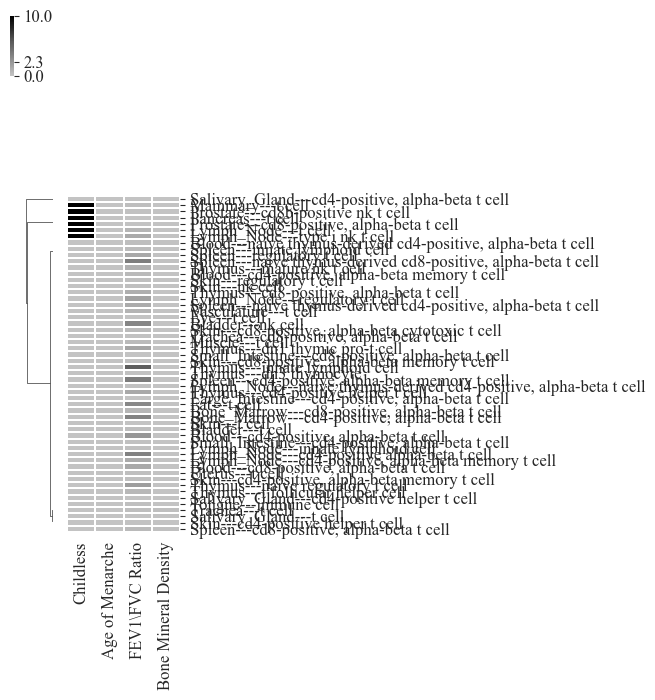

In [109]:

x = -np.log10(0.005 + epsilon)
data = alltraits_significant[alltraits_significant['Cluster']==19][["Childless","Age of Menarche","FEV1\FVC Ratio","Bone Mineral Density"]]
cg = sns.clustermap(data, cmap='Greys',  figsize=(2, 6),
                    yticklabels=True, xticklabels=True,
                    linewidths=0.05, linecolor='white',
                    # yticklabels=True, xticklabels=False,
                    row_cluster=True, col_cluster=False, 
                    method='weighted', metric='cosine',
                    
                    # method='complete', metric='cosine',
                    cbar_pos=(0.05, 0.87, 0.02, 0.1),
                    cbar_kws={'ticks': [0, x, 10]},
                    center=x)  #行是组织，列是性状


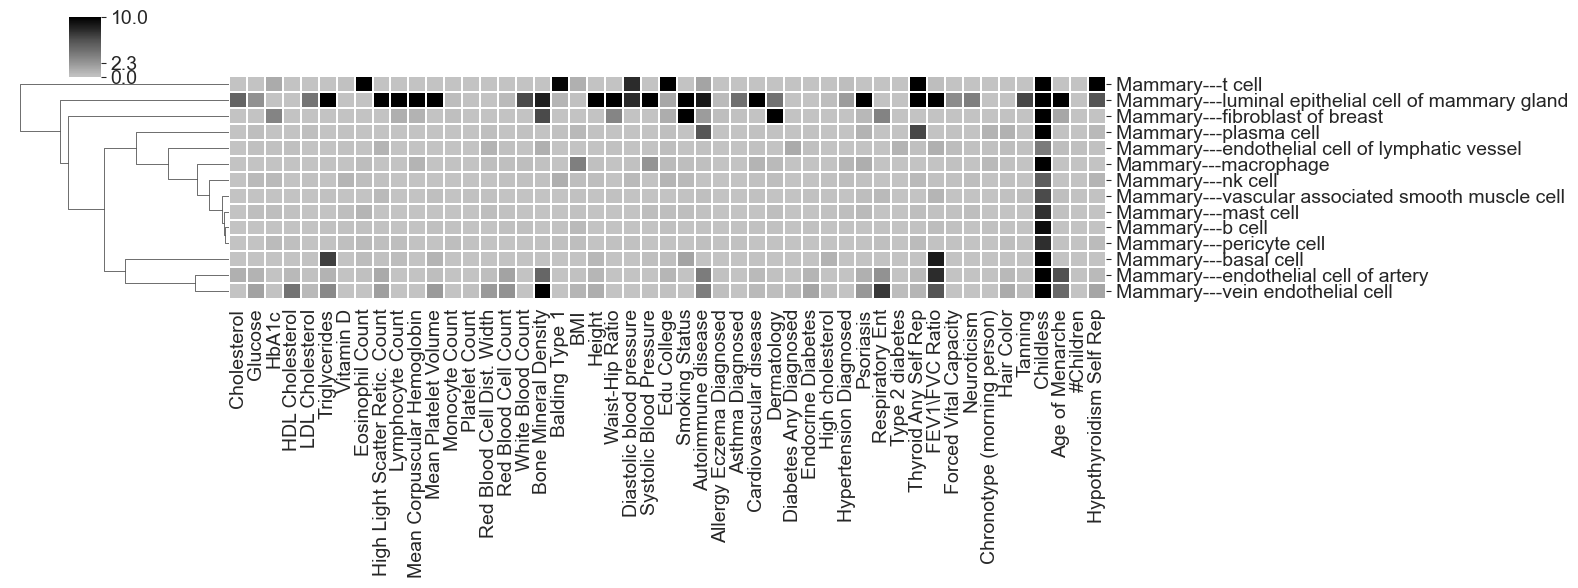

In [5]:
ct_name = list(alltraits_significant.index)
# 筛选包含 'b cell' 子串的所有元素
filtered_name = [item for item in ct_name if 'mammary' in item.lower()]
# 根据索引筛选行
filtered_df = alltraits_significant.loc[filtered_name]

x = -np.log10(0.005 + epsilon)
# data = alltraits_significant[alltraits_significant['Cluster']==19]
# data = alltraits_significant[alltraits_significant['Cluster']==19][["Childless","Age of Menarche","FEV1\FVC Ratio","Bone Mineral Density"]]
cg = sns.clustermap(filtered_df.iloc[:,0:-1], cmap='Greys',figsize = (16,6),
                    yticklabels=True, xticklabels=True,
                    linewidths=0.05, linecolor='white',
                    # yticklabels=True, xticklabels=False,
                    row_cluster=True, col_cluster=False, 
                    method='weighted', metric='cosine',
                    
                    # method='complete', metric='cosine',
                    cbar_pos=(0.05, 0.87, 0.02, 0.1),
                    cbar_kws={'ticks': [0, x, 10]},
                    center=x)  #行是组织，列是性状

In [91]:
filtered_df

胆固醇           葡萄糖        糖化血红蛋白  \
Bladder---b cell                7.899955e-06  2.592306e+00  2.280409e-02   
Blood---memory b cell          -4.342945e-11  1.000000e+01  1.814645e-01   
Blood---naive b cell           -4.342945e-11  1.000000e+01  5.062416e-02   
Bone_Marrow---memory b cell     8.336611e-14  6.152024e+00  2.571264e-01   
Bone_Marrow---naive b cell      8.975323e-06  9.758525e-01  1.490044e-02   
Eye---b cell                   -4.342945e-11  7.060899e-01  1.088590e-03   
Fat---b cell                   -4.342945e-11  5.387538e-02 -4.342945e-11   
Kidney---b cell                -4.342945e-11  2.994615e+00  7.132723e-03   
Large_Intestine---b cell       -4.342945e-11  3.390967e-01  3.084207e-04   
Lung---b cell                   6.828829e-04  5.754530e-02  3.938192e-03   
Lymph_Node---b cell            -4.342945e-11  1.000000e+01 -4.342945e-11   
Lymph_Node---memory b cell     -4.342945e-11  1.000000e+01  8.491341e-09   
Lymph_Node---naive b cell      -4.342945e-11  1.000000e+01  7.529113e-03   
Mammary---b cell               -4.342945e-11  1.217290e-02 -4.342945e-11   
Pancreas---b cell               1.274606e-03  1.826513e-01  6.709946e-02   
Salivary_Gland---b cell         2.250509e+00  1.134116e+00  6.516986e-01   
Salivary_Gland---memory b cell -4.342945e-11  1.000000e+01  6.878079e-01   
Salivary_Gland---naive b cell  -4.342945e-11  1.000000e+01  5.034355e-01   
Skin---memory b cell           -4.342945e-11 -4.342945e-11  3.010300e-01   
Skin---naive b cell            -4.342945e-11 -4.342945e-11  6.368221e-01   
Small_Intestine---b cell       -4.342945e-11  3.415688e-02  1.116600e-01   
Spleen---memory b cell         -4.342945e-11  1.000000e+01  3.010300e-01   
Spleen---naive b cell          -4.342945e-11  1.000000e+01  7.813930e-02   
Thymus---b cell                -4.342945e-11  2.333700e+00  1.714623e-08   
Thymus---memory b cell         -4.342945e-11  1.000000e+01  2.048720e-05   
Thymus---naive b cell          -4.342945e-11  1.000000e+01  1.385135e+00   
Trachea---b cell               -4.342945e-11  4.279938e-01  3.403677e-01   
Uterus---b cell                -4.342945e-11  3.010300e-01 -4.342945e-11   
Vasculature---b cell           -4.342945e-11  6.883595e-01  5.347585e-02   

                                   高密度脂蛋白胆固醇     低密度脂蛋白胆固醇          甘油三酯  \
Bladder---b cell                5.940269e-03  2.280409e-02  5.940269e-03   
Blood---memory b cell           6.656794e-01  2.551469e-04  3.628269e-09   
Blood---naive b cell            6.259714e-07 -4.342945e-11 -4.342945e-11   
Bone_Marrow---memory b cell     1.817476e-01  7.939346e-03  2.848867e-04   
Bone_Marrow---naive b cell      2.654073e-02  3.370961e-03  3.370961e-03   
Eye---b cell                    2.339091e-02  1.079084e-02 -4.342945e-11   
Fat---b cell                    5.387538e-02  5.387538e-02 -4.342945e-11   
Kidney---b cell                 5.833629e-04  3.310215e-05  5.206271e-06   
Large_Intestine---b cell        4.455372e-08  1.305969e-09  7.701805e-07   
Lung---b cell                  -4.342945e-11  5.754530e-02  6.828829e-04   
Lymph_Node---b cell            -2.193758e-11 -4.342945e-11 -4.342945e-11   
Lymph_Node---memory b cell      1.731868e-03 -4.342945e-11 -4.342945e-11   
Lymph_Node---naive b cell       2.589693e-04 -4.334449e-11 -4.342945e-11   
Mammary---b cell                1.217290e-02  1.217290e-02  1.059919e-01   
Pancreas---b cell               2.659018e-02  1.826513e-01  9.026685e-06   
Salivary_Gland---b cell         1.201695e-02  1.733034e+00  9.257972e-02   
Salivary_Gland---memory b cell  1.000763e-05  1.464052e-08  4.800816e-08   
Salivary_Gland---naive b cell   1.677879e-02 -3.889383e-11 -4.252887e-11   
Skin---memory b cell           -4.342945e-11 -4.342945e-11 -4.342945e-11   
Skin---naive b cell             3.010300e-01 -4.342945e-11 -4.342945e-11   
Small_Intestine---b cell        5.047906e-09  3.395089e-06  4.718809e-03   
Spleen---memory b cell          1.903121e-07 -4.342945e-11 -4.342945e-11   
Spleen---nai

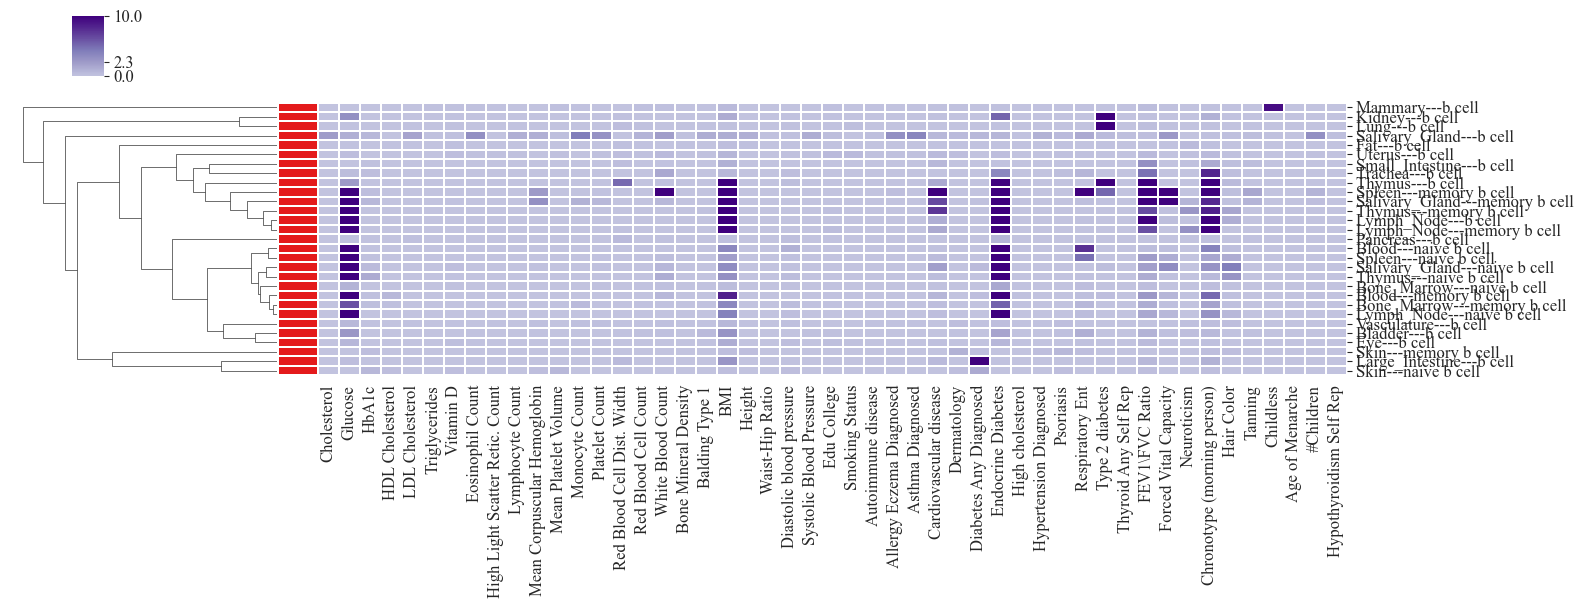

In [108]:
ct_name = list(alltraits_significant.index)
# 筛选包含 'b cell' 子串的所有元素
filtered_name = [item for item in ct_name if 'b cell' in item.lower()]
filtered_bcell = [item for item in filtered_name if 'club cell' not in item.lower()]
filtered_df = alltraits_significant.loc[filtered_bcell]
## 第14簇
cluster14 = alltraits_significant[alltraits_significant['Cluster']==14]  #紫色
cluster14_ct = list(cluster14.index)

# labels = np.array(['A', 'B', 'A', 'B', 'C', 'C', 'A', 'B', 'C', 'A'])

x = -np.log10(0.005 + epsilon)
# 设置颜色映射
# 根据第一列的值设置标签
labels = np.where(filtered_df.iloc[:, -1] == 14, 1, 0)
palette = sns.color_palette('Set1', len(np.unique(labels)))
lut = dict(zip(np.unique(labels), palette))
row_colors = pd.Series(labels, index=filtered_df.index).map(lut)


cg = sns.clustermap(filtered_df.iloc[:,0:-1], cmap='Purples',figsize = (16,6),
                    row_colors=row_colors,
                    yticklabels=True, xticklabels=True,
                    linewidths=0.05, linecolor='white',
                    # yticklabels=True, xticklabels=False,
                    row_cluster=True, col_cluster=False, 
                    method='weighted', metric='cosine',
                    
                    # method='complete', metric='cosine',
                    cbar_pos=(0.05, 0.9, 0.02, 0.1),
                    cbar_kws={'ticks': [0, x, 10]},
                    center=x)  #行是组织，列是性状
# 添加图例
for label in np.unique(labels):
    cg.ax_row_dendrogram.bar(0, 0, color=lut[label], label=label, linewidth=0)
# cg.ax_row_dendrogram.legend(loc="center", ncol=len(np.unique(labels)))


plt.show()

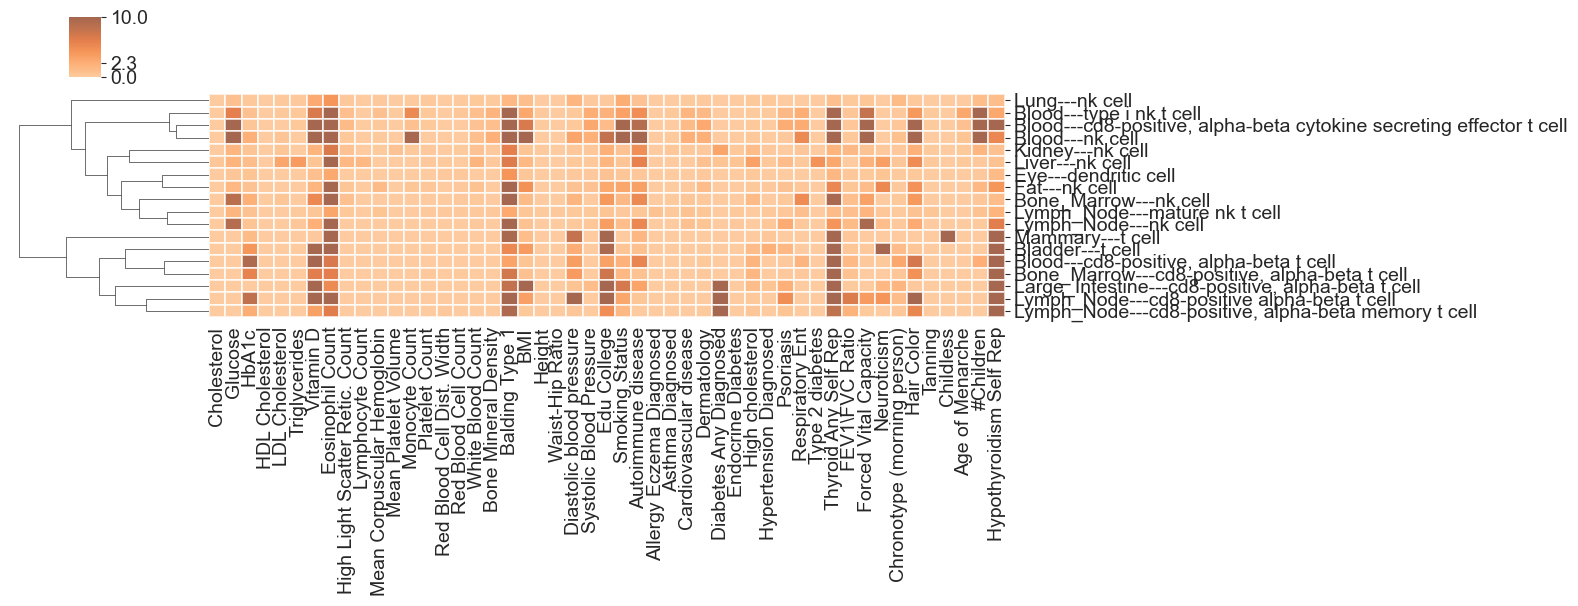

In [36]:
cluster7 = alltraits_significant[alltraits_significant['Cluster']==7]  # 橙色
# 根据索引筛选行
filtered_df = alltraits_significant[alltraits_significant['Cluster']==7] 

x = -np.log10(0.005 + epsilon)
# data = alltraits_significant[alltraits_significant['Cluster']==19]
# data = alltraits_significant[alltraits_significant['Cluster']==19][["Childless","Age of Menarche","FEV1\FVC Ratio","Bone Mineral Density"]]
cg = sns.clustermap(filtered_df.iloc[:,0:-1], cmap='Oranges',figsize = (16,6),alpha = 0.7,
                    yticklabels=True, xticklabels=True,
                    linewidths=0.05, linecolor='white',
                    # yticklabels=True, xticklabels=False,
                    row_cluster=True, col_cluster=False, 
                    method='weighted', metric='cosine',
                    
                    # method='complete', metric='cosine',
                    cbar_pos=(0.05, 0.9, 0.02, 0.1),
                    cbar_kws={'ticks': [0, x, 10]},
                    center=x)  #行是组织，列是性状